In [134]:
#######################################################################################
# End to End Machine Learning with Feature Engineering & Data Preprocessing
# Hyperparameter Optimization on Titanic
#######################################################################################
! pip install catboost

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
# !pip install missingno
import missingno as msno
from datetime import date
from sklearn.metrics import accuracy_score
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)


def load_data():
    data = pd.read_csv("titanic.csv")
    return data

df = load_data()
df.head()

df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000,1,0,A/5 21171,7.250,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000,1,0,PC 17599,71.283,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000,0,0,STON/O2. 3101282,7.925,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000,1,0,113803,53.100,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.000,0,0,373450,8.050,NaN,S


In [135]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [136]:
#####################################################
# EDA
#####################################################
def check_df(dataframe):
    print ("##################### Shape #####################")
    print (dataframe.shape)
    print ("##################### Types #####################")
    print (dataframe.dtypes)
    print ("##################### Head #####################")
    print (dataframe.head (3))
    print ("##################### Tail #####################")
    print (dataframe.tail (3))
    print ("##################### NA #####################")
    print (dataframe.isnull ().sum ())
    print ("##################### Quantiles #####################")
    print (dataframe.quantile ([0, 0.05, 0.50, 0.95, 0.99, 1]).T)


check_df (df)

##################### Shape #####################
(891, 12)
##################### Types #####################
PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object
##################### Head #####################
   PassengerId  Survived  Pclass                                               Name     Sex    Age  SibSp  Parch            Ticket   Fare Cabin Embarked
0            1         0       3                            Braund, Mr. Owen Harris    male 22.000      1      0         A/5 21171  7.250   NaN        S
1            2         1       1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female 38.000      1      0          PC 17599 71.283   C85        C
2            3         1       3                             Heikkinen, Miss. Laina  female 

<ipython-input-136-f227ec4a1199>:16: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  print (dataframe.quantile ([0, 0.05, 0.50, 0.95, 0.99, 1]).T)


In [137]:
####################################
# NUMERIC AND CATEGORICAL VARIABLES
####################################
# First of there is a need to know which ones are numeric, categorical, cardinal
# More importantly to understand numeric looking categoricals and categoric looking cardinals
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """
    grab_col_names for given dataframe

    :param dataframe:
    :param cat_th:
    :param car_th:
    :return:
    """

    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]

    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique () < cat_th and
                   dataframe[col].dtypes != "O"]

    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique () > car_th and
                   dataframe[col].dtypes == "O"]

    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print (f"Observations: {dataframe.shape[0]}")
    print (f"Variables: {dataframe.shape[1]}")
    print (f'cat_cols: {len (cat_cols)}')
    print (f'num_cols: {len (num_cols)}')
    print (f'cat_but_car: {len (cat_but_car)}')
    print (f'num_but_cat: {len (num_but_cat)}')

    # cat_cols + num_cols + cat_but_car = değişken sayısı.
    # num_but_cat cat_cols'un içerisinde zaten.
    # dolayısıyla tüm şu 3 liste ile tüm değişkenler seçilmiş olacaktır: cat_cols + num_cols + cat_but_car
    # num_but_cat sadece raporlama için verilmiştir.

    return cat_cols, cat_but_car, num_cols


cat_cols, cat_but_car, num_cols = grab_col_names (df)

Observations: 891
Variables: 12
cat_cols: 6
num_cols: 3
cat_but_car: 3
num_but_cat: 4


In [138]:
cat_cols

['Sex', 'Embarked', 'Survived', 'Pclass', 'SibSp', 'Parch']

In [139]:
cat_but_car

['Name', 'Ticket', 'Cabin']

In [140]:
num_cols

['PassengerId', 'Age', 'Fare']

In [141]:
#Id is classfied in numeric columns which is not good
num_cols =[col for col in num_cols if col not in "PassengerId"]
num_cols

['Age', 'Fare']

        Sex  Ratio
male    577 64.759
female  314 35.241
##########################################


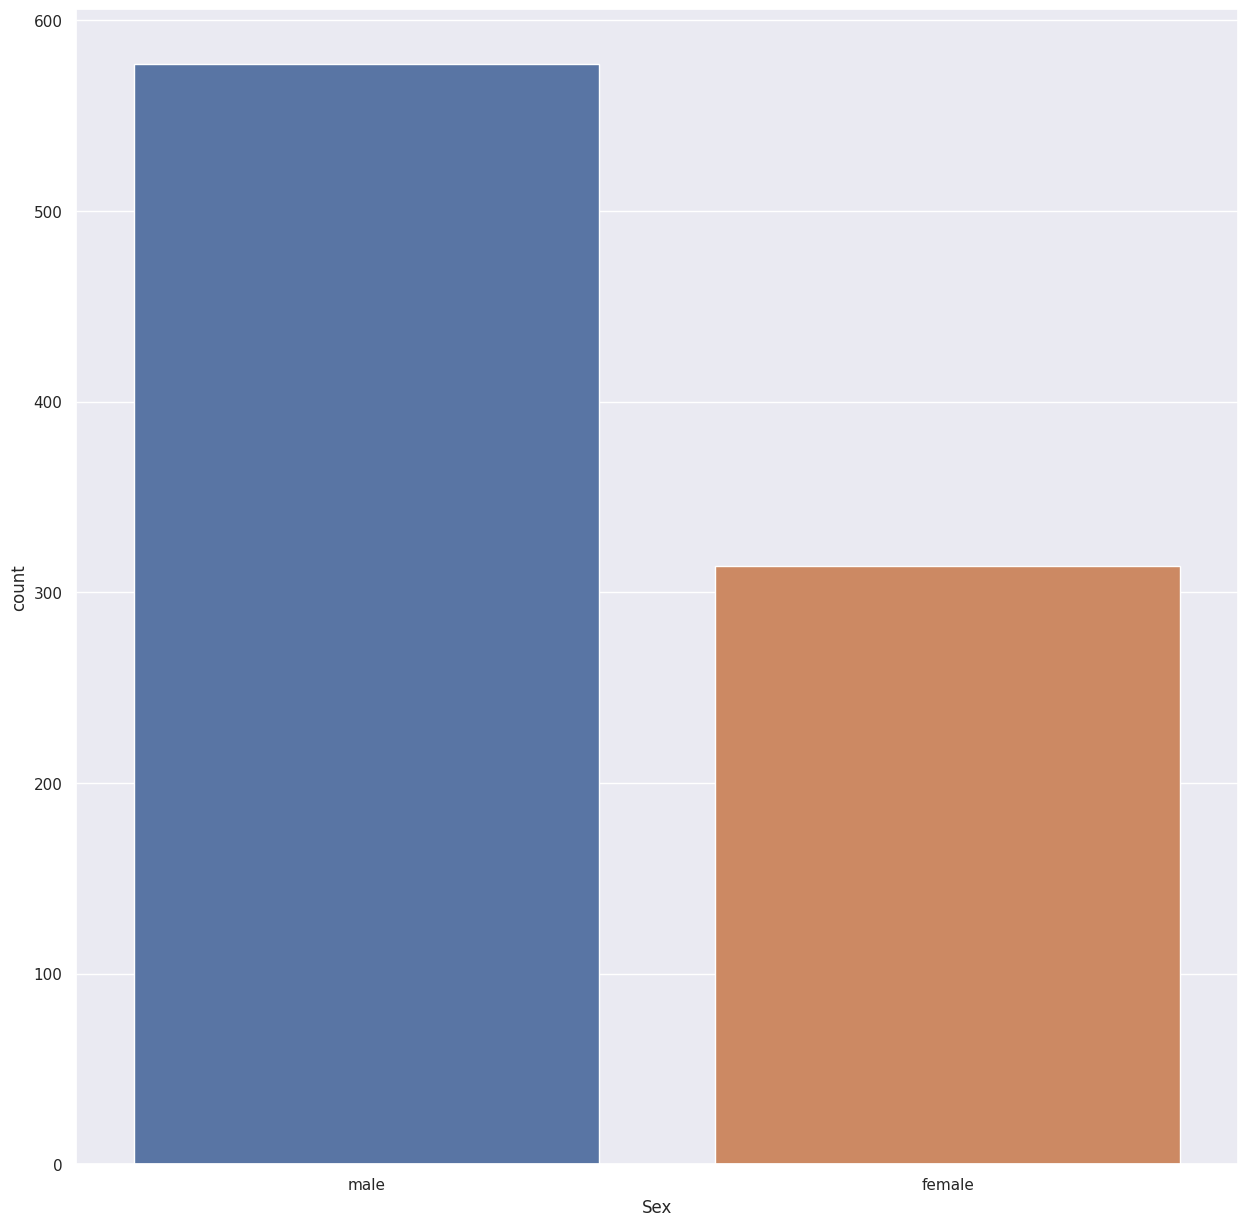

   Embarked  Ratio
S       644 72.278
C       168 18.855
Q        77  8.642
##########################################


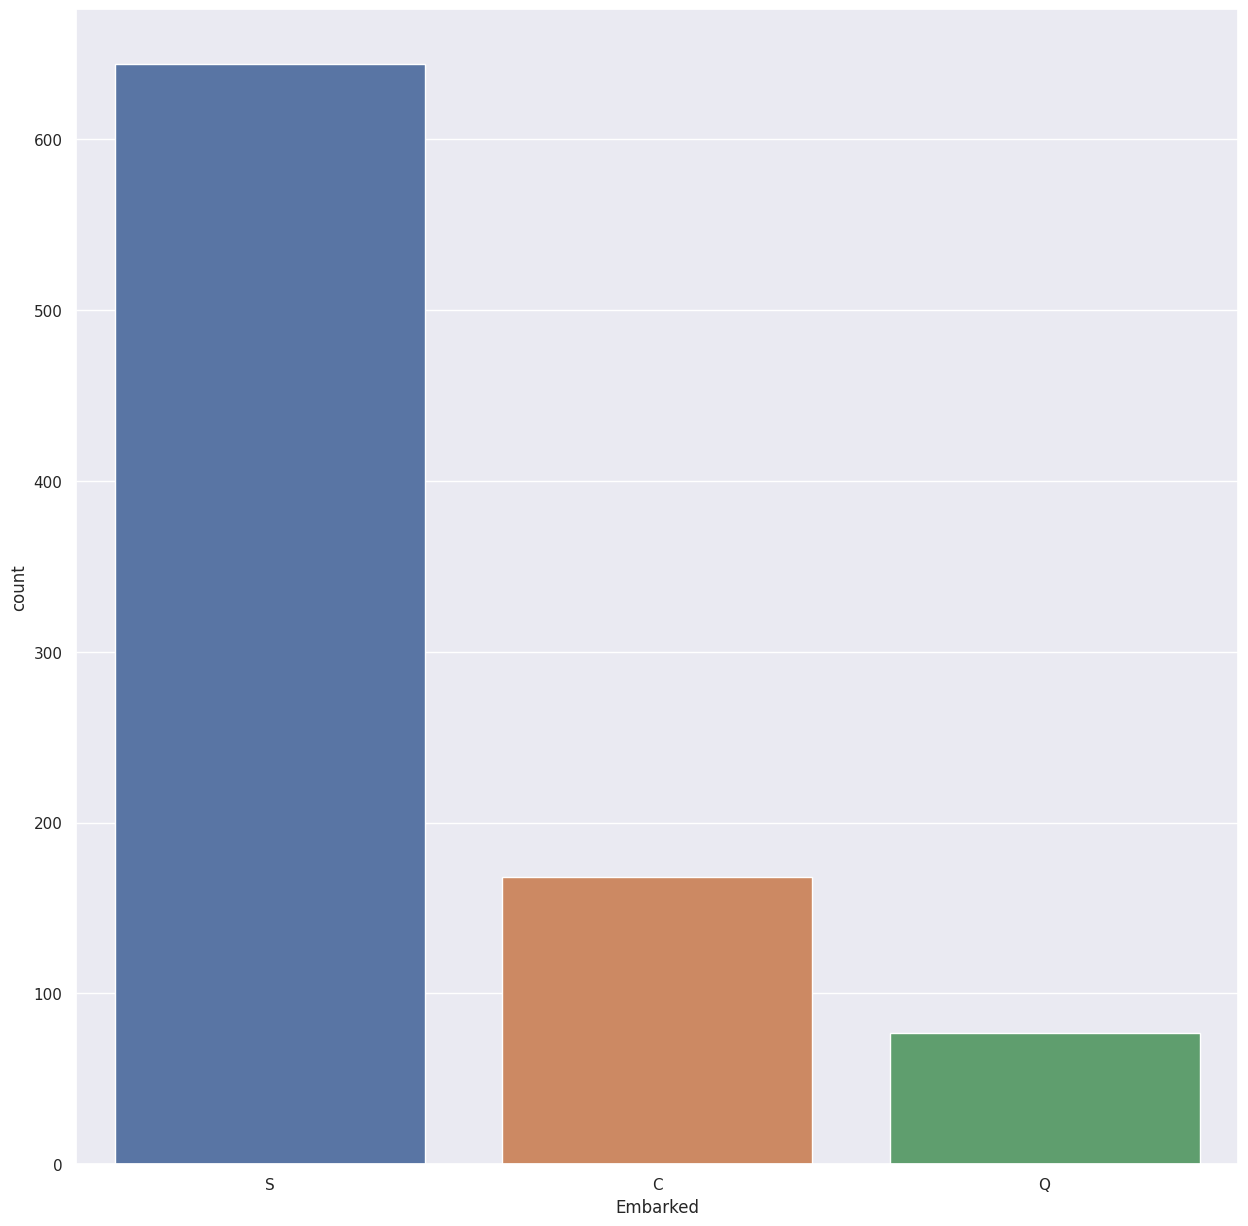

   Survived  Ratio
0       549 61.616
1       342 38.384
##########################################


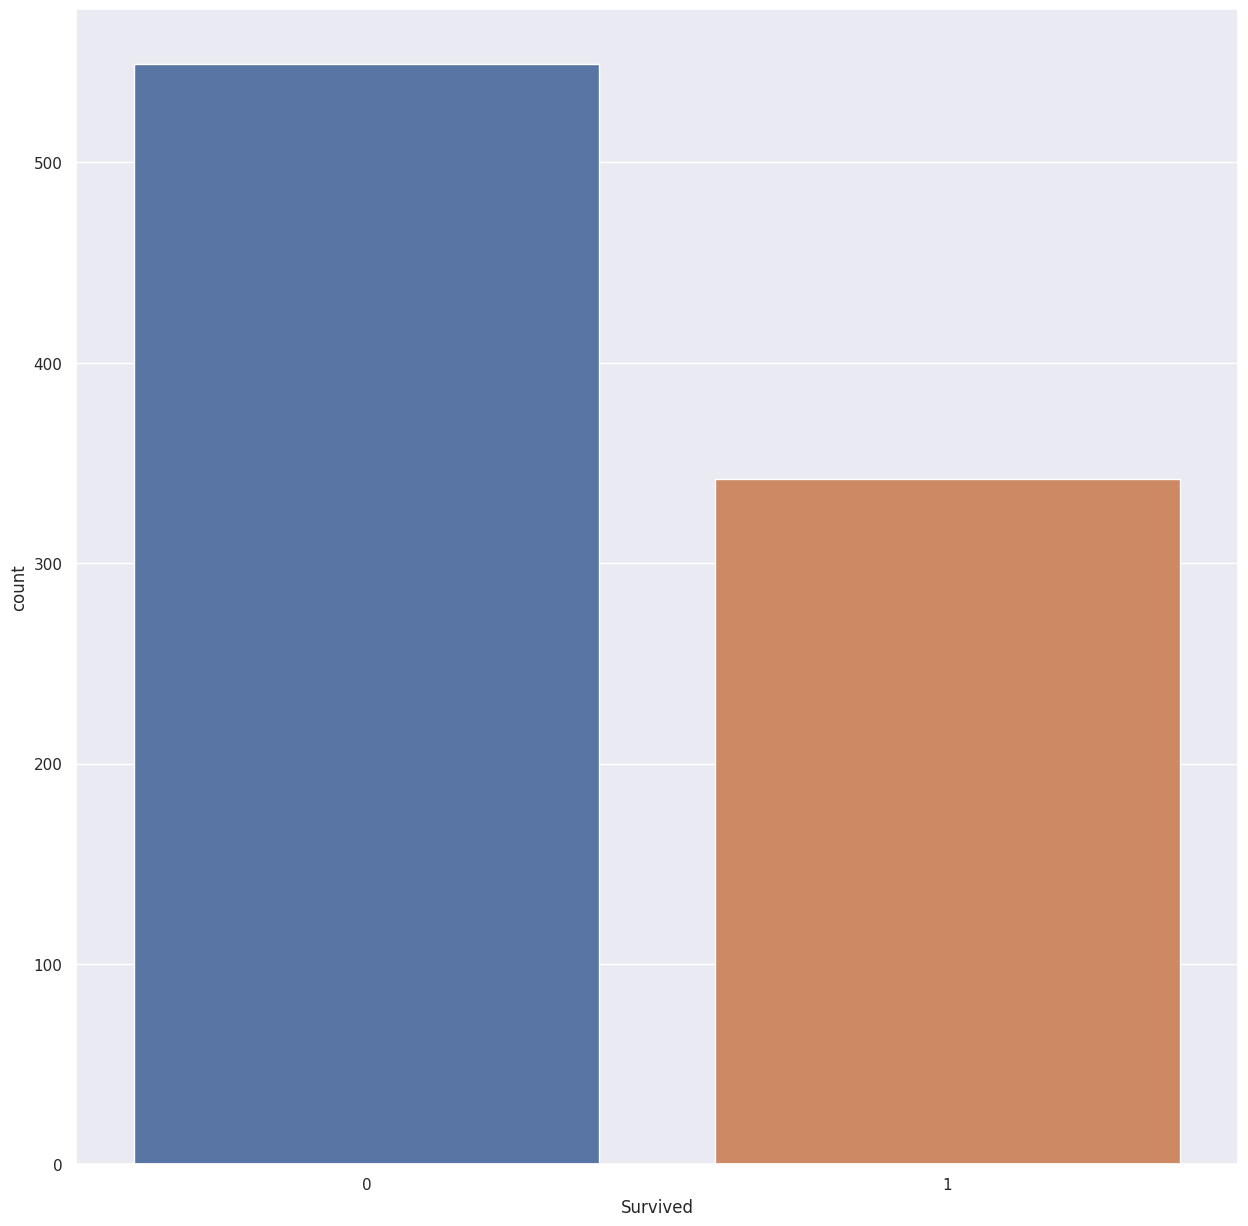

   Pclass  Ratio
3     491 55.107
1     216 24.242
2     184 20.651
##########################################


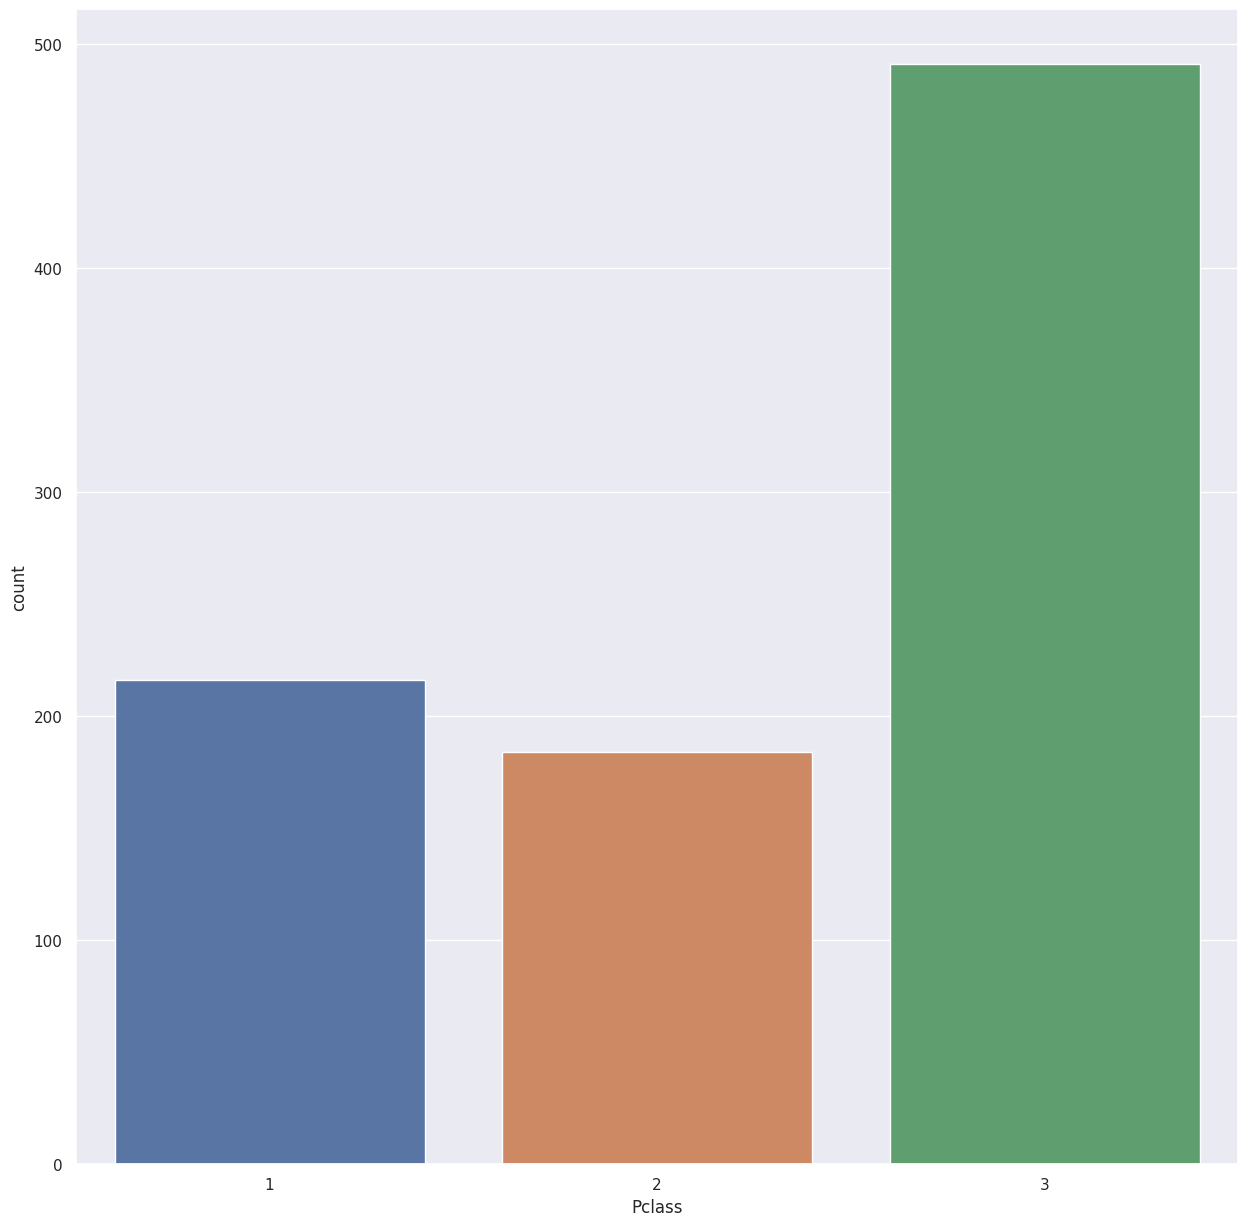

   SibSp  Ratio
0    608 68.238
1    209 23.457
2     28  3.143
4     18  2.020
3     16  1.796
8      7  0.786
5      5  0.561
##########################################


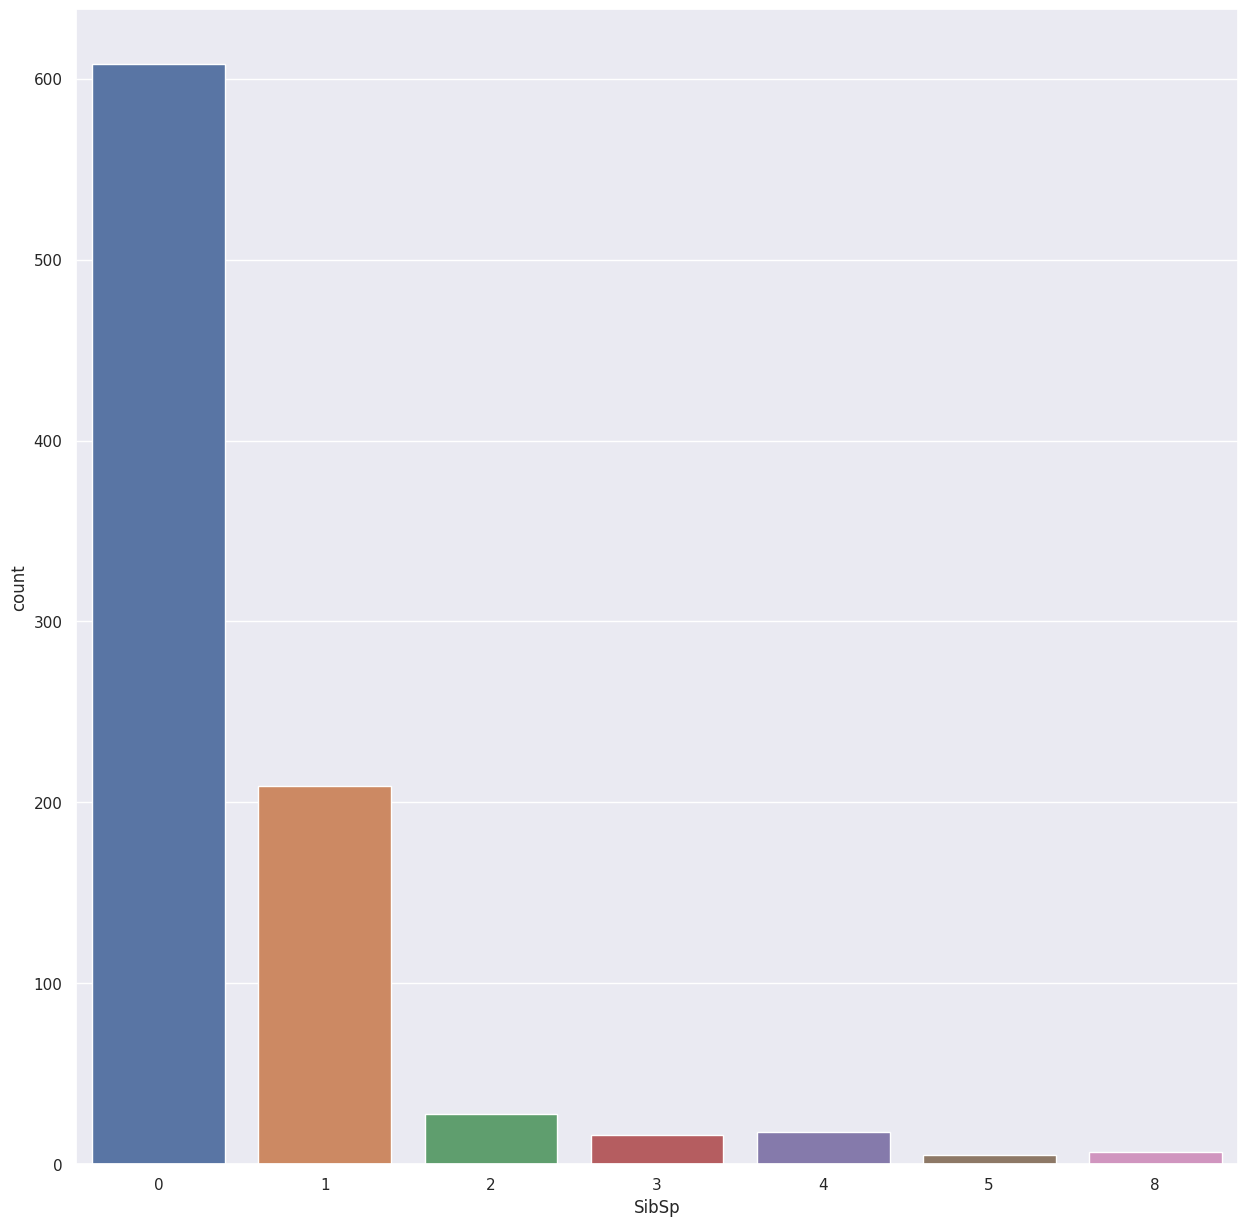

   Parch  Ratio
0    678 76.094
1    118 13.244
2     80  8.979
5      5  0.561
3      5  0.561
4      4  0.449
6      1  0.112
##########################################


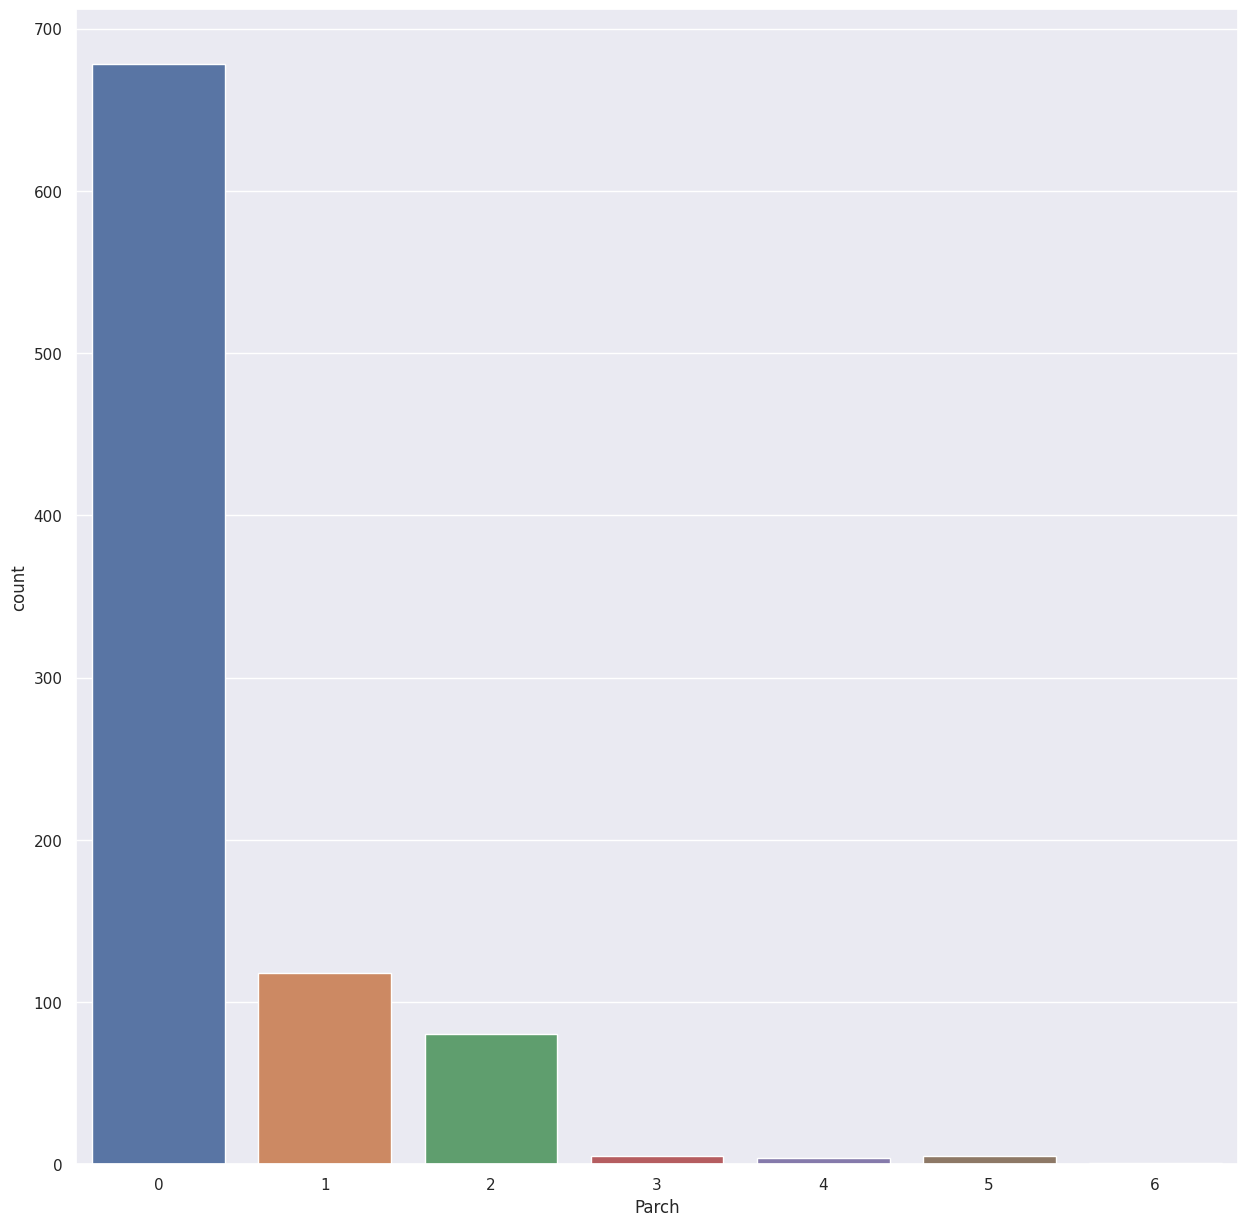

In [142]:
######################################
# Analysis of Categorical Variables
######################################
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")

    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show(block=True)


for col in cat_cols:
    cat_summary(df, col, plot=True)

count   714.000
mean     29.699
std      14.526
min       0.420
5%        4.000
10%      14.000
20%      19.000
30%      22.000
40%      25.000
50%      28.000
60%      31.800
70%      36.000
80%      41.000
90%      50.000
95%      56.000
99%      65.870
max      80.000
Name: Age, dtype: float64


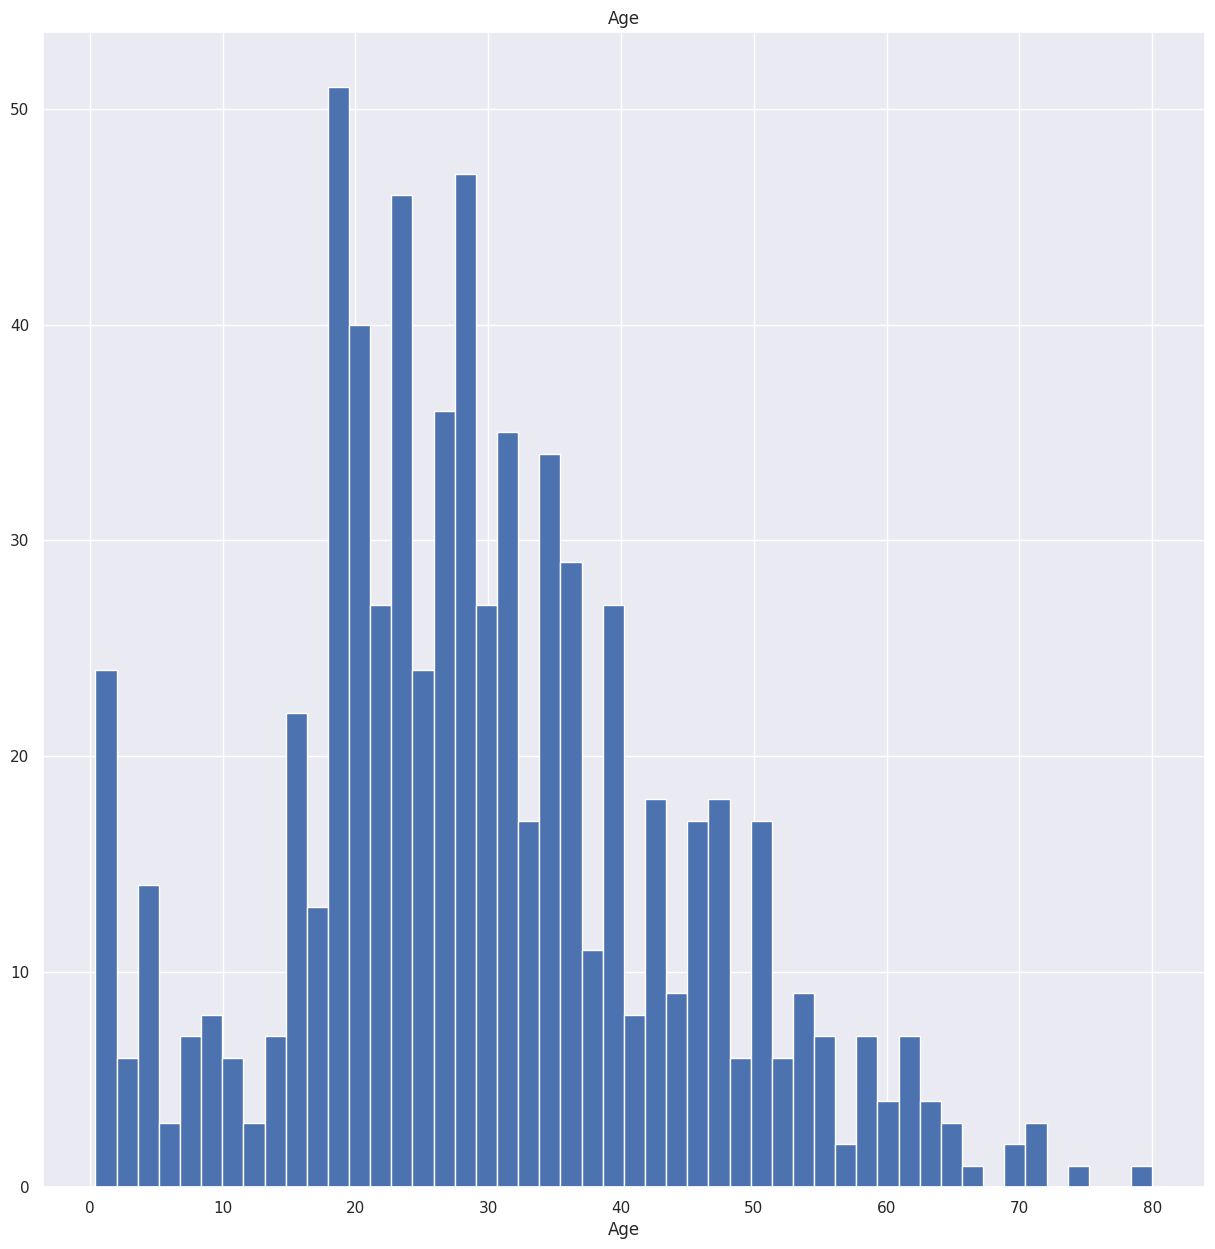

#####################################
count   891.000
mean     32.204
std      49.693
min       0.000
5%        7.225
10%       7.550
20%       7.854
30%       8.050
40%      10.500
50%      14.454
60%      21.679
70%      27.000
80%      39.688
90%      77.958
95%     112.079
99%     249.006
max     512.329
Name: Fare, dtype: float64


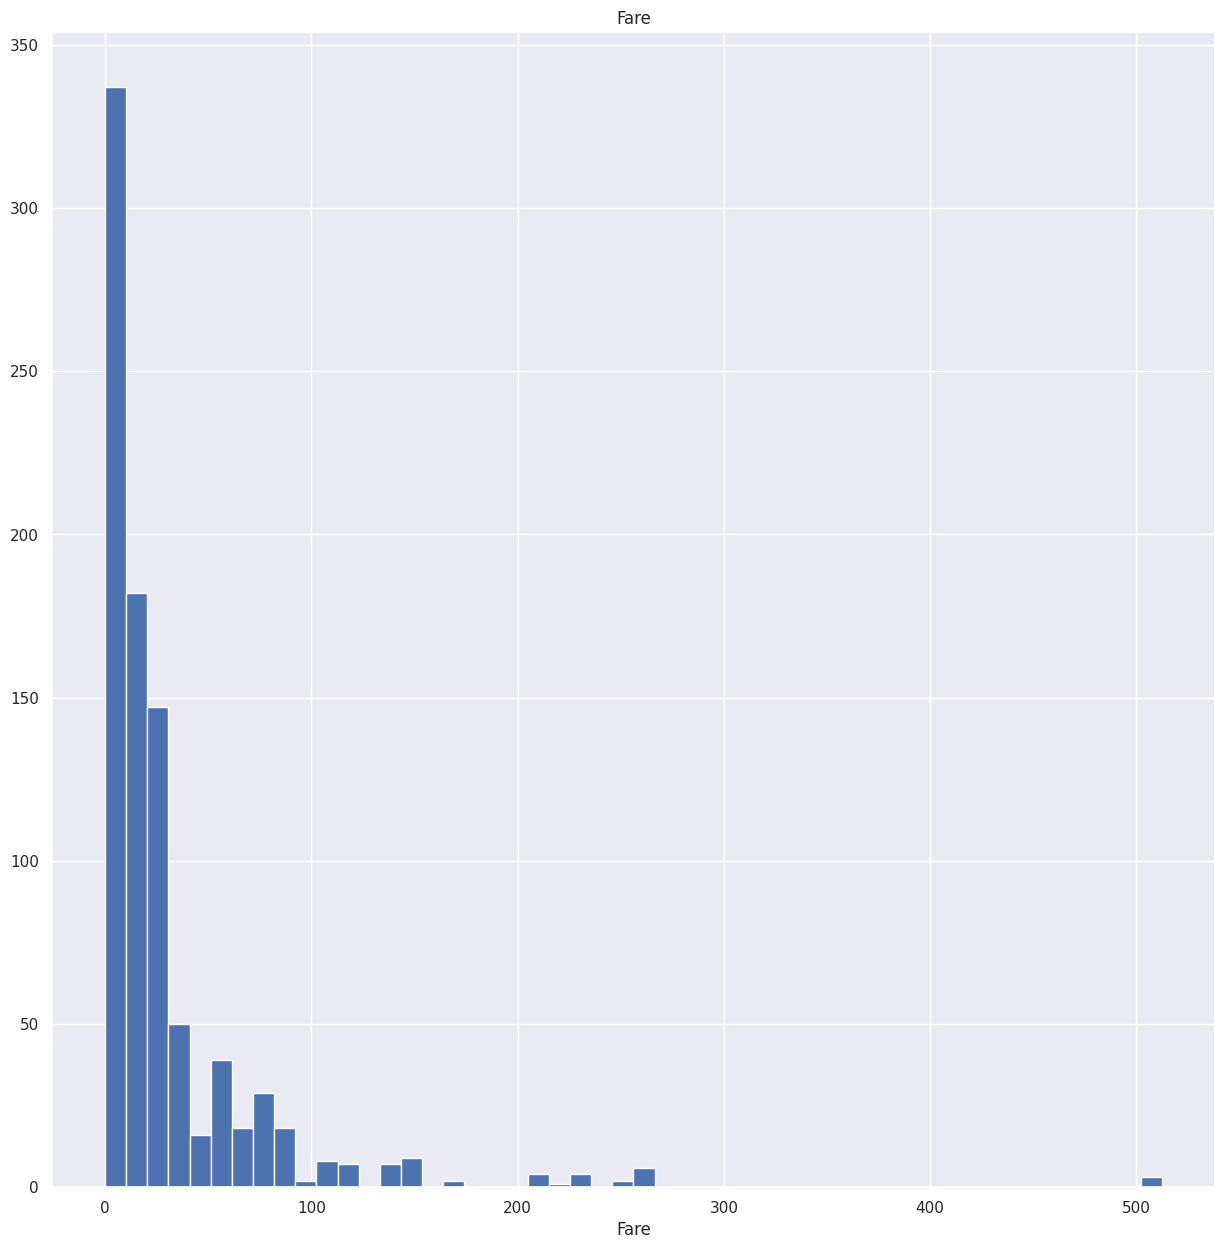

#####################################
       count   mean    std   min    5%    10%    20%    30%    40%    50%    60%    70%    80%    90%     95%     99%     max
Age  714.000 29.699 14.526 0.420 4.000 14.000 19.000 22.000 25.000 28.000 31.800 36.000 41.000 50.000  56.000  65.870  80.000
Fare 891.000 32.204 49.693 0.000 7.225  7.550  7.854  8.050 10.500 14.454 21.679 27.000 39.688 77.958 112.079 249.006 512.329
#####################################


In [143]:
######################################
# Analysis of Numerical Variables
######################################

def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print (dataframe[numerical_col].describe (quantiles).T)

    if plot:
        dataframe[numerical_col].hist (bins=50)
        plt.xlabel (numerical_col)
        plt.title (numerical_col)
        plt.show ()

    print ("#####################################")


for col in num_cols:
    num_summary (df, col, True)
num_summary(df,num_cols)

In [144]:
############################################################################
# Analysis of Target Variable with Categorical Columns if Target is Numeric
############################################################################

def target_summary_with_cat(dataframe, target, categorical_col):
    print (pd.DataFrame ({"TARGET_MEAN": dataframe.groupby (categorical_col)[target].mean ()}), end="\n\n\n")


#for col in cat_cols:
    target_summary_with_cat (df, "Survived", col)
## if target is numeric
# Target Analysis Graph,
#df["Survived"].hist (bins=100)
#plt.title("Survived")

plt.show()

# if target is numeric!!
# Log transformation on target variable,
#Log transformation of target variable help lessens the distance between the data points
# and result in the better model
#np.log1p (df['Survived']).hist (bins=50)
#plt.title("Survived")
# plt.show ()

<Axes: xlabel='Survived', ylabel='count'>

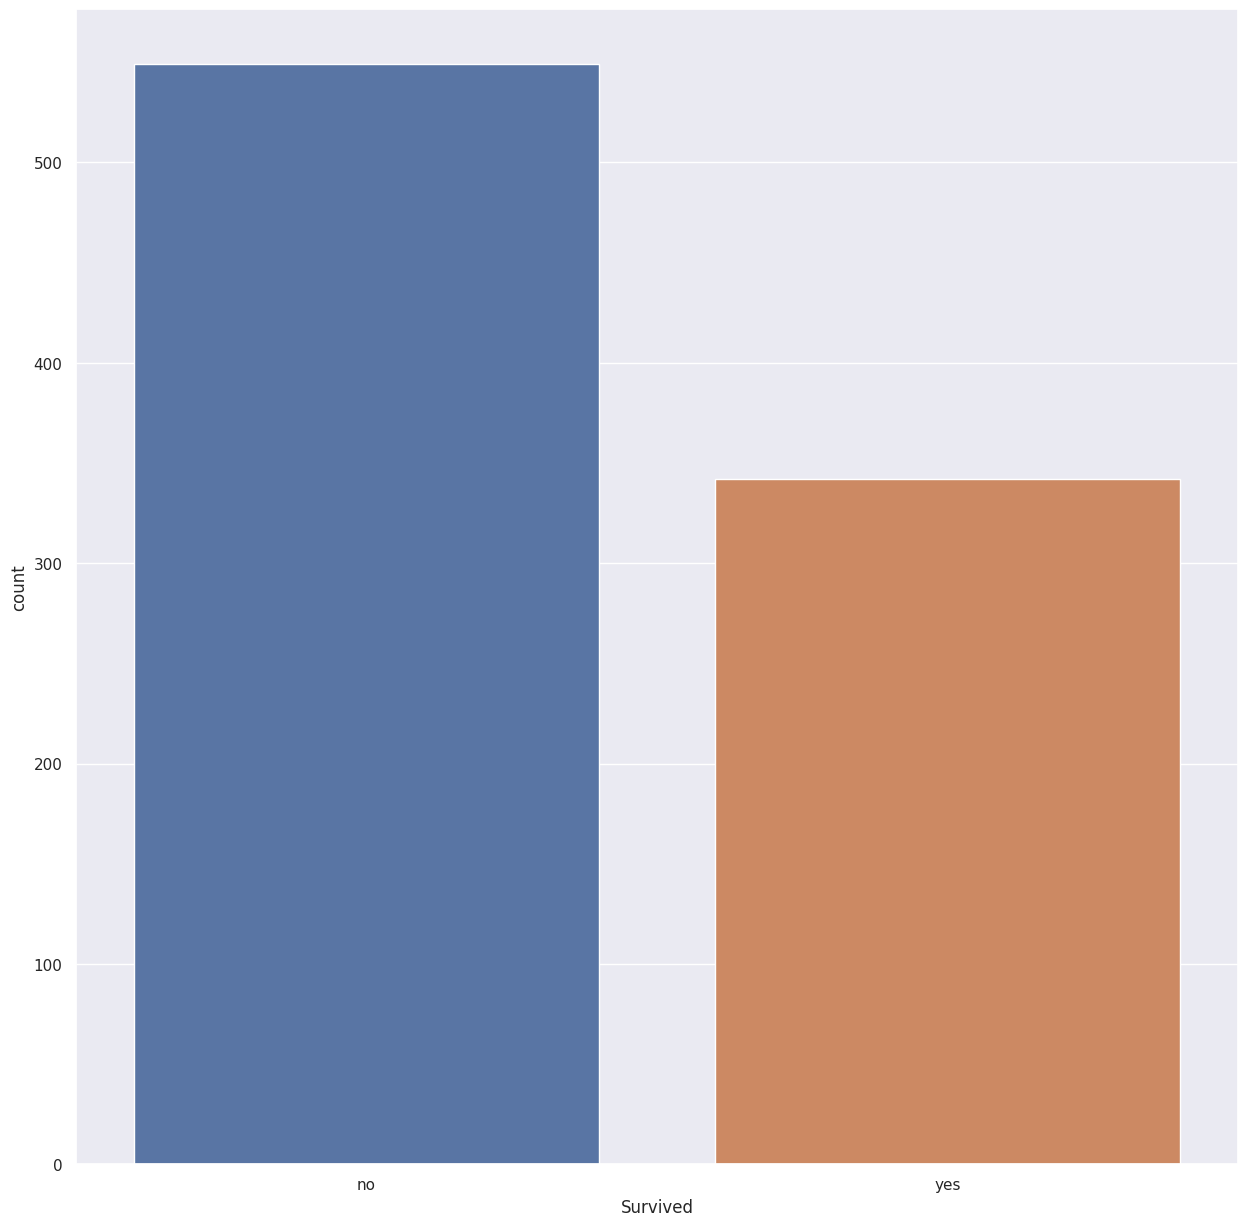

In [145]:
#Instead, here a simmple graphic drawn again, same as previous lines above
#Since this case has a binary target
sns.countplot(x="Survived" ,
            data=df.replace({"Survived" : {1 : "yes", 0 : "no"}}))

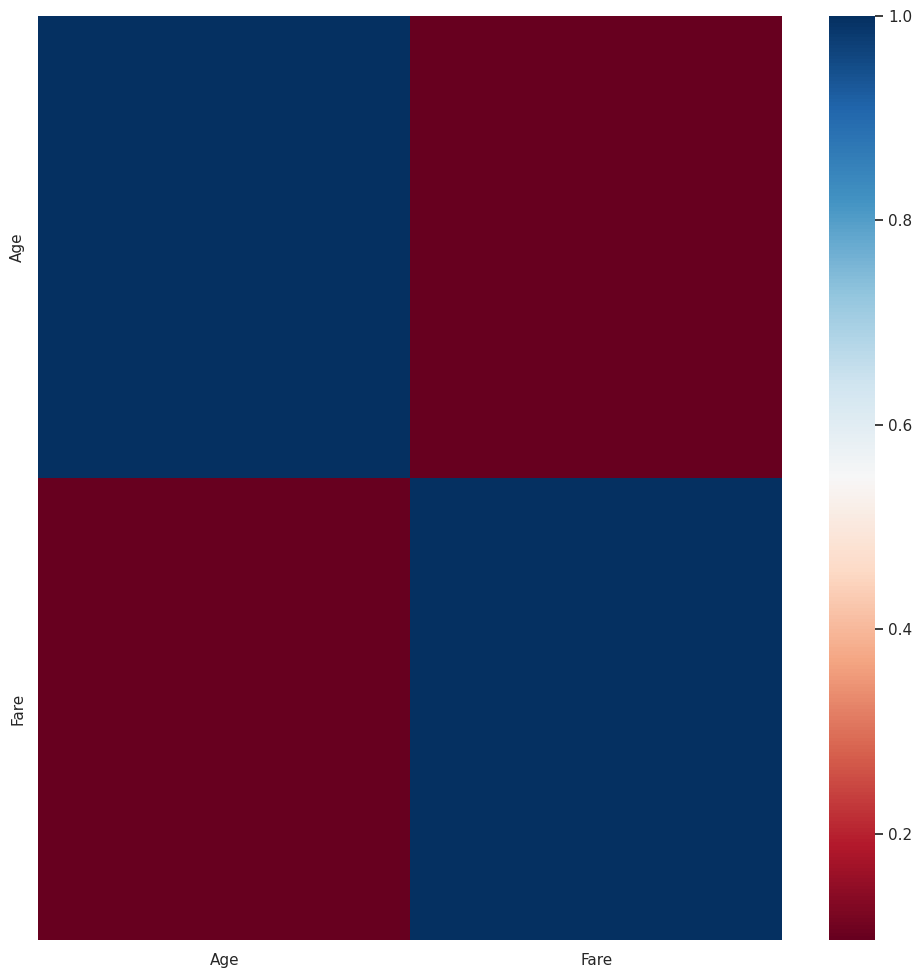

In [146]:
######################################
# Analysis of Correlation Matrix
######################################

corr = df[num_cols].corr ()
corr

# Correlation Plotting
sns.set (rc={'figure.figsize': (12, 12)})
sns.heatmap (corr, cmap="RdBu")
plt.show ()

<ipython-input-147-167b65171494>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = dataframe.corr ()
<ipython-input-147-167b65171494>:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper_triangle_matrix = cor_matrix.where (np.triu (np.ones (cor_matrix.shape), k=1).astype (np.bool))


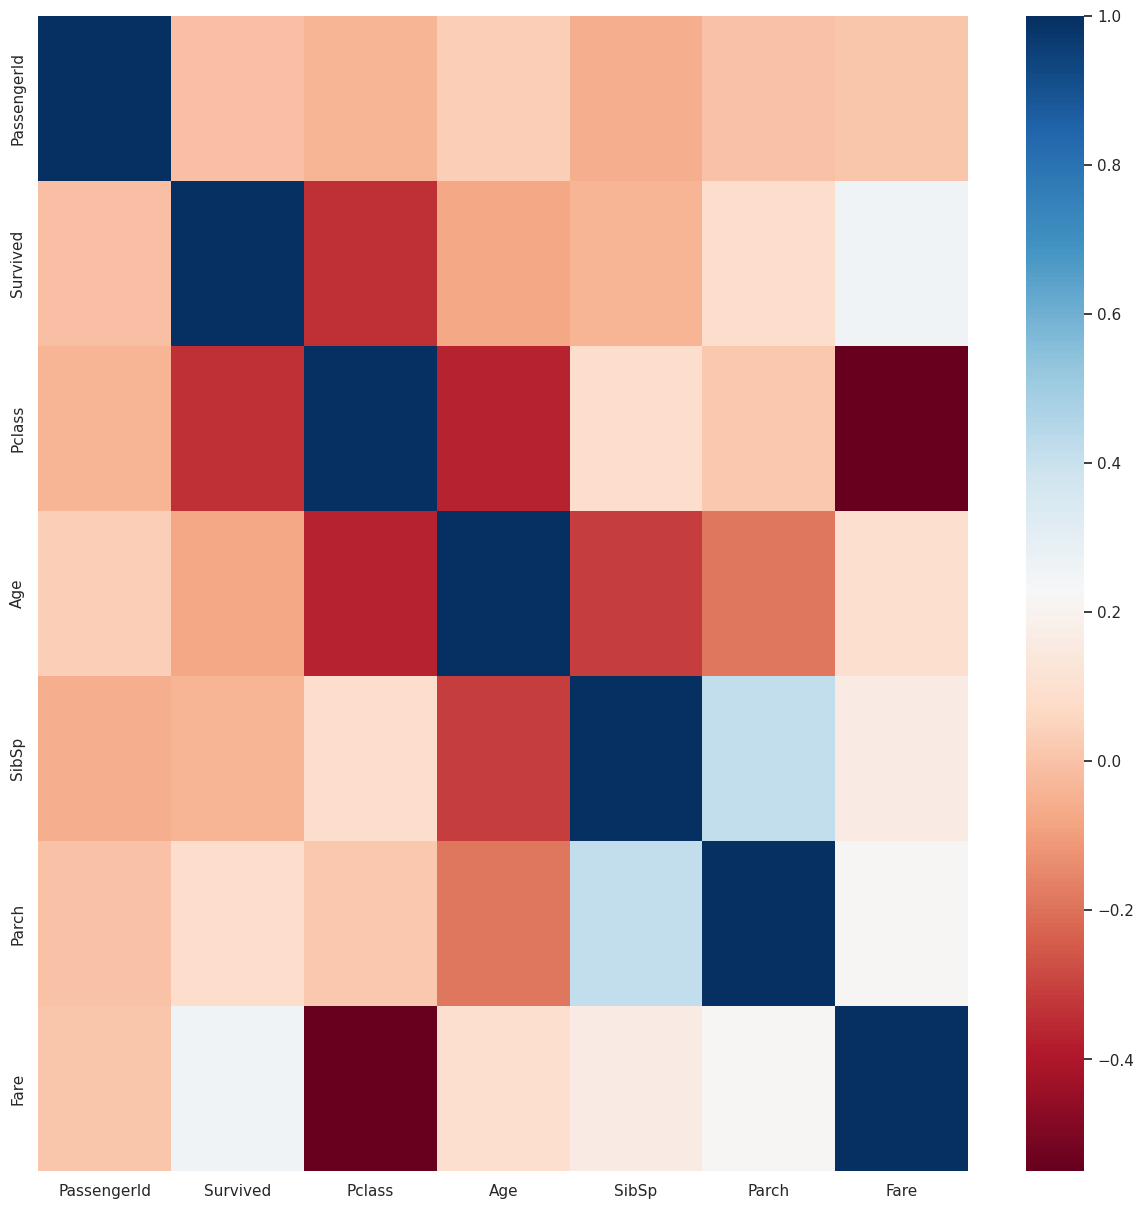

[]

In [147]:
# Analysis of Higly Correlated Variables
def high_correlated_cols(dataframe, plot=False, corr_th=0.70):
    corr = dataframe.corr ()
    cor_matrix = corr.abs ()
    upper_triangle_matrix = cor_matrix.where (np.triu (np.ones (cor_matrix.shape), k=1).astype (np.bool))
    drop_list = [col for col in upper_triangle_matrix.columns if any (upper_triangle_matrix[col] > corr_th)]
    if plot:
        import seaborn as sns
        import matplotlib.pyplot as plt
        sns.set (rc={'figure.figsize': (15, 15)})
        sns.heatmap (corr, cmap="RdBu")
        plt.show ()
    return drop_list


high_correlated_cols (df, plot=True)


In [148]:
######################################
# Feature Engineering
######################################

######################################
# Outlier analysis
######################################

def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [149]:
low, up = outlier_thresholds(df, "Fare")

In [150]:
outlier_thresholds(df, "Fare")

(-150.056225, 269.360375)

In [151]:
# Here are outliers of Fare have been printed  as index numbers
df[(df["Fare"] < low) | (df["Fare"] > up)].index

Int64Index([258, 679, 737], dtype='int64')

In [152]:
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

check_outlier(df, "Age")

False

In [153]:
# Replacing with Thresholds
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds (dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

# Here it is to run replacement with thresholds
for col in num_cols:
    if col != "SalePrice":
        replace_with_thresholds (df, col)

 I will not replace with threshold at this moment,
 First I prefer to run Multivariate outlier detection which is Local Outlier Factor

In [154]:
 #########################################
 #Local Outlier Factor
 #########################################
clf = LocalOutlierFactor(n_neighbors=20)
df1 = df.dropna()
df1 = df1.select_dtypes(include=['float64', 'int64'])

clf.fit_predict(df1)

for col in df1.columns:
    print(col, check_outlier(df1, col))
    # there are outliers as individual columns

PassengerId False
Survived False
Pclass False
Age False
SibSp True
Parch False
Fare False


In [155]:
df_scores = clf.negative_outlier_factor_
df_scores[0:5]
df_scores = -df_scores
np.sort(df_scores)[0:10]


array([0.96364817, 0.96374344, 0.96504021, 0.9679735 , 0.96801729,
       0.96935787, 0.97148239, 0.97256043, 0.97261555, 0.97314532])

In [156]:
len(df_scores)

183

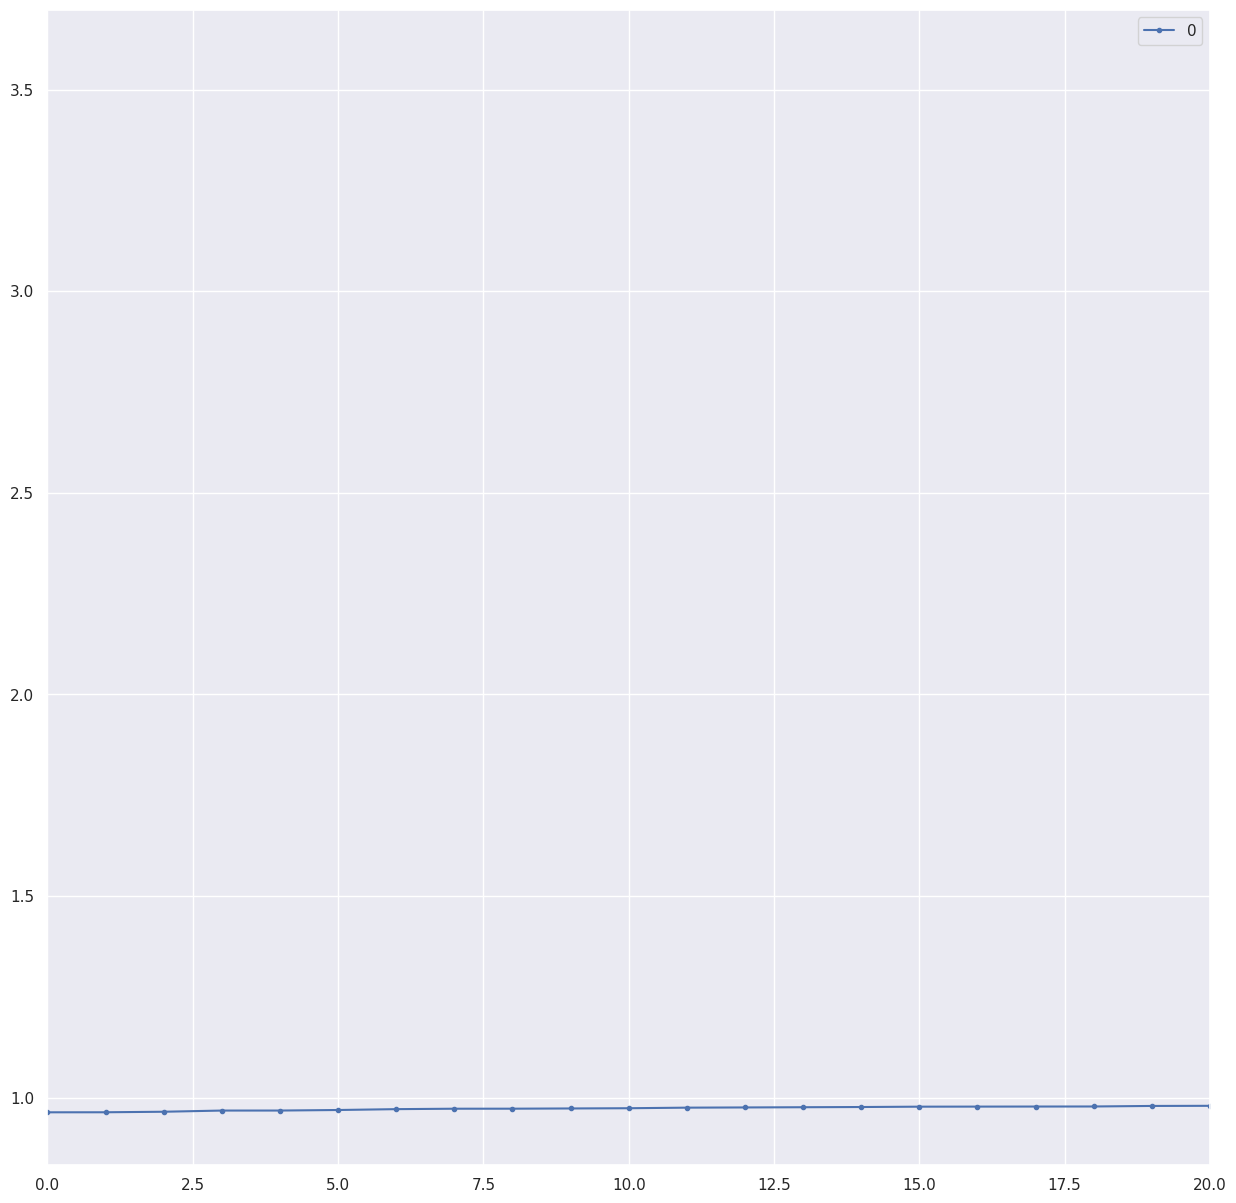

In [157]:
scores = pd.DataFrame(np.sort(df_scores))
scores.plot(stacked=True, xlim=[0, 20], style='.-')
plt.show()
# As it seen before on the chart below; there is not any sharp change on slope.
# Even there are outliers on individual colums we may still ignore outliers

In [158]:
# However just as an example, I Like run replace with thresholds function
# And I will set low limit and up limit as : 0.05 and 0.95
# It will help us to replace THE SHARPEST OUTLIERS only!
# It is just an example strategy

def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

for col in num_cols:
    replace_with_thresholds(df, col)
# Check if any outlier left out
for col in num_cols:
    print(col, check_outlier(df, col))

Age False
Fare False


In [159]:
######################################
# Missing Values
######################################
# sum of nulls
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [160]:
na_cols = [col for col in df.columns if df[col].isnull().sum() > 0]
na_cols

['Age', 'Cabin', 'Embarked']

In [161]:
# create a missing values table
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")

    if na_name:
        return na_columns


In [162]:
missing_values_table(df, True)

          n_miss  ratio
Cabin        687 77.100
Age          177 19.870
Embarked       2  0.220


['Age', 'Cabin', 'Embarked']

In [163]:
# Solving Missing Values Problem
# Just as a demonstration example KNN Imputer will be utilized

#Knn Algorithms needs an encoding first. One-hot Encoding has been implemented
#cat_cols and num_col have been identified before with as below functions
#cat_cols, num_cols, cat_but_car = grab_col_names(df)
#num_cols = [col for col in num_cols if col not in "PassengerId"]
dff = pd.get_dummies(df[cat_cols + num_cols], drop_first=True)

dff.head()

# Let's Standardize The Variables for KNN Imputer Predictions
scaler = MinMaxScaler()
dff = pd.DataFrame(scaler.fit_transform(dff), columns=dff.columns)


In [164]:
# Implementing KNN Imputer
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)
dff = pd.DataFrame(imputer.fit_transform(dff), columns=dff.columns)
#Knn has been completed
dff.head()

# Now there is a need to take inverse values of standartscaled dataframe
# Bcoz. we need real values back
dff = pd.DataFrame(scaler.inverse_transform(dff), columns=dff.columns)

In [165]:
# Now Imputed values are to be placed as new variable
df["age_imputed_knn"] = dff[["Age"]]
df["age_imputed_knn"].isnull().sum()

0

In [166]:
# Cabin and embarked columns have a different story. So antoher approach will be followed

# We have a new question
# Do missing values have a correlation with Target?

missing_values_table(df, True)
na_cols = missing_values_table(df, True)


def missing_vs_target(dataframe, target, na_columns):
    temp_df = dataframe.copy()

    for col in na_columns:
        temp_df[col + '_NA_FLAG'] = np.where(temp_df[col].isnull(), 1, 0)

    na_flags = temp_df.loc[:, temp_df.columns.str.contains("_NA_")].columns

    for col in na_flags:
        print(pd.DataFrame({"TARGET_MEAN": temp_df.groupby(col)[target].mean(),
                            "Count": temp_df.groupby(col)[target].count()}), end="\n\n\n")


missing_vs_target(df, "Survived", na_cols)

          n_miss  ratio
Cabin        687 77.100
Age          177 19.870
Embarked       2  0.220
          n_miss  ratio
Cabin        687 77.100
Age          177 19.870
Embarked       2  0.220
             TARGET_MEAN  Count
Age_NA_FLAG                    
0                  0.406    714
1                  0.294    177


               TARGET_MEAN  Count
Cabin_NA_FLAG                    
0                    0.667    204
1                    0.300    687


                  TARGET_MEAN  Count
Embarked_NA_FLAG                    
0                       0.382    889
1                       1.000      2




In [167]:
# As you see above people with No-Cabin number has 77 % of very high frequency!!
# And more interestingly, people with No-Cabin number has low very low rate of survive!!
# When we investigate the reason, It was found out that no-cabin persons were mostly crew member on the ship
# This info will hep us to understand the fact that we need another strategy for Missing Values of Cabin
# In feature engineering part, we can create variable called cabin_bool;
# Which is to classify if people have cabin number or not

In [168]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,age_imputed_knn
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000,1,0,A/5 21171,7.250,NaN,S,22.000
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000,1,0,PC 17599,65.634,C85,C,38.000
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000,0,0,STON/O2. 3101282,7.925,NaN,S,26.000
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000,1,0,113803,53.100,C123,S,35.000
4,5,0,3,"Allen, Mr. William Henry",male,35.000,0,0,373450,8.050,NaN,S,35.000


In [169]:
###################################################
#FEATURE EXTREACTIONS
###################################################
#CREATION OF NEW FEATURES AND TAGGING THEM AS NEW
###################################################

#############################################
# #################
# Letter Count
###################

df["NEW_NAME_COUNT"] = df["Name"].str.len()
#############################################

###################
# Word Count
###################

df["NEW_NAME_WORD_COUNT"] = df["Name"].apply(lambda x: len(str(x).split(" ")))

###################
#  Abstraction of Doctors
###################

df["NEW_NAME_DR"] = df["Name"].apply(lambda x: len([x for x in x.split() if x.startswith("Dr")]))

df.groupby("NEW_NAME_DR").agg({"Survived": ["mean","count"]})
# Below this feature is seen very helpful, doctors has hight rare of survival


Survived      
                mean count
NEW_NAME_DR               
0              0.383   881
1              0.500    10

In [170]:
##########################
# New Features with Regex
##########################

df.head()

df['NEW_TITLE'] = df.Name.str.extract(' ([A-Za-z]+)\.', expand=False)


df[["NEW_TITLE", "Survived", "Age"]].groupby(["NEW_TITLE"]).agg({"Survived": "mean", "Age": ["count", "mean"]})
# As seen below, People having title "Miss" has high rate of survival with. 0.698

Survived   Age       
              mean count   mean
NEW_TITLE                      
Capt         0.000     1 64.812
Col          0.500     2 58.000
Countess     1.000     1 33.000
Don          0.000     1 40.000
Dr           0.429     6 42.000
Jonkheer     0.000     1 38.000
Lady         1.000     1 48.000
Major        0.500     2 48.500
Master       0.575    36  4.574
Miss         0.698   146 21.774
Mlle         1.000     2 24.000
Mme          1.000     1 24.000
Mr           0.157   398 32.244
Mrs          0.792   108 35.898
Ms           1.000     1 28.000
Rev          0.000     6 43.167
Sir          1.000     1 49.000

In [171]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   PassengerId          891 non-null    int64  
 1   Survived             891 non-null    int64  
 2   Pclass               891 non-null    int64  
 3   Name                 891 non-null    object 
 4   Sex                  891 non-null    object 
 5   Age                  714 non-null    float64
 6   SibSp                891 non-null    int64  
 7   Parch                891 non-null    int64  
 8   Ticket               891 non-null    object 
 9   Fare                 891 non-null    float64
 10  Cabin                204 non-null    object 
 11  Embarked             889 non-null    object 
 12  age_imputed_knn      891 non-null    float64
 13  NEW_NAME_COUNT       891 non-null    int64  
 14  NEW_NAME_WORD_COUNT  891 non-null    int64  
 15  NEW_NAME_DR          891 non-null    int

In [172]:
#############################################
# Feature Interactions
#############################################
df["NEW_AGE_PCLASS"] = df["age_imputed_knn"] * df["Pclass"]

df["NEW_FAMILY_SIZE"] = df["SibSp"] + df["Parch"] + 1

df.loc[(df['Sex'] == 'male') & (df['Age'] <= 21), 'NEW_SEX_CAT'] = 'youngmale'

df.loc[(df['Sex'] == 'male') & (df['Age'] > 21) & (df['Age'] < 50), 'NEW_SEX_CAT'] = 'maturemale'

df.loc[(df['Sex'] == 'male') & (df['Age'] >= 50), 'NEW_SEX_CAT'] = 'seniormale'

df.loc[(df['Sex'] == 'female') & (df['Age'] <= 21), 'NEW_SEX_CAT'] = 'youngfemale'

df.loc[(df['Sex'] == 'female') & (df['Age'] > 21) & (df['Age'] < 50), 'NEW_SEX_CAT'] = 'maturefemale'

df.loc[(df['Sex'] == 'female') & (df['Age'] >= 50), 'NEW_SEX_CAT'] = 'seniorfemale'
df.loc[((df['SibSp'] + df['Parch']) > 0), "NEW_IS_ALONE"] = "NO"
df.loc[((df['SibSp'] + df['Parch']) == 0), "NEW_IS_ALONE"] = "YES"

df.head()

df.groupby("NEW_SEX_CAT")["Survived"].mean()

# As seen below, mature female category has highest rate of survival with 0.774

NEW_SEX_CAT
maturefemale   0.774
maturemale     0.199
seniorfemale   0.909
seniormale     0.135
youngfemale    0.679
youngmale      0.250
Name: Survived, dtype: float64

In [173]:
df.groupby("NEW_IS_ALONE")["Survived"].mean()
# Alone person has a low rate of survive

NEW_IS_ALONE
NO    0.506
YES   0.304
Name: Survived, dtype: float64

In [174]:
##########################################################################
# LET'S CHECK IF SOME OF THE NEW VARIABLES ARE "statistically significant"
##########################################################################

#  Z score test for two population proportions will be utilized
# Both variables have statistically significant classes

df["NEW_CABIN_BOOL"] = df["Cabin"].notnull().astype('int')

df.groupby("NEW_CABIN_BOOL").agg({"Survived": "mean"})

from statsmodels.stats.proportion import proportions_ztest

test_stat, pvalue = proportions_ztest(count=[df.loc[df["NEW_CABIN_BOOL"] == 1, "Survived"].sum(),
                                             df.loc[df["NEW_CABIN_BOOL"] == 0, "Survived"].sum()],

                                      nobs=[df.loc[df["NEW_CABIN_BOOL"] == 1, "Survived"].shape[0],
                                            df.loc[df["NEW_CABIN_BOOL"] == 0, "Survived"].shape[0]])
print('Test Stat = %.4f, p-value = %.4f' % (test_stat, pvalue))

Test Stat = 9.4597, p-value = 0.0000


In [175]:
df.groupby("NEW_IS_ALONE").agg({"Survived": "mean"})


test_stat, pvalue = proportions_ztest(count=[df.loc[df["NEW_IS_ALONE"] == "YES", "Survived"].sum(),
                                             df.loc[df["NEW_IS_ALONE"] == "NO", "Survived"].sum()],

                                      nobs=[df.loc[df["NEW_IS_ALONE"] == "YES", "Survived"].shape[0],
                                            df.loc[df["NEW_IS_ALONE"] == "NO", "Survived"].shape[0]])

print('Test Stat = %.4f, p-value = %.4f' % (test_stat, pvalue))

Test Stat = -6.0704, p-value = 0.0000


In [176]:
#############################################
# Encoding, One-Hot Encoding, Rare Encoding
#############################################

In [177]:
#############################################
# Rare Encoding
#############################################

# Unneccesary classes in variables cause negative impacts on;
# iteration, optimization and the Bagging process on decision trees
# This is why rare anaylsis is an affective tool to filter nonessential classes

############################################
# 1. Rare Encoding for Categoric Variables.
############################################

def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show()


for col in cat_cols:
    cat_summary(df, col)

        Sex  Ratio
male    577 64.759
female  314 35.241
##########################################
   Embarked  Ratio
S       644 72.278
C       168 18.855
Q        77  8.642
##########################################
   Survived  Ratio
0       549 61.616
1       342 38.384
##########################################
   Pclass  Ratio
3     491 55.107
1     216 24.242
2     184 20.651
##########################################
   SibSp  Ratio
0    608 68.238
1    209 23.457
2     28  3.143
4     18  2.020
3     16  1.796
8      7  0.786
5      5  0.561
##########################################
   Parch  Ratio
0    678 76.094
1    118 13.244
2     80  8.979
5      5  0.561
3      5  0.561
4      4  0.449
6      1  0.112
##########################################


In [178]:
################################
# 2. Rare Analysis with Target.
################################

def rare_analyser(dataframe, target, cat_cols):
    for col in cat_cols:
        print(col, ":", len(dataframe[col].value_counts()))
        print(pd.DataFrame({"COUNT": dataframe[col].value_counts(),
                            "RATIO": dataframe[col].value_counts() / len(dataframe),
                            "TARGET_MEAN": dataframe.groupby(col)[target].mean()}), end="\n\n\n")

rare_analyser(df, "Survived", cat_cols)

Sex : 2
        COUNT  RATIO  TARGET_MEAN
female    314  0.352        0.742
male      577  0.648        0.189


Embarked : 3
   COUNT  RATIO  TARGET_MEAN
C    168  0.189        0.554
Q     77  0.086        0.390
S    644  0.723        0.337


Survived : 2
   COUNT  RATIO  TARGET_MEAN
0    549  0.616        0.000
1    342  0.384        1.000


Pclass : 3
   COUNT  RATIO  TARGET_MEAN
1    216  0.242        0.630
2    184  0.207        0.473
3    491  0.551        0.242


SibSp : 7
   COUNT  RATIO  TARGET_MEAN
0    608  0.682        0.345
1    209  0.235        0.536
2     28  0.031        0.464
3     16  0.018        0.250
4     18  0.020        0.167
5      5  0.006        0.000
8      7  0.008        0.000


Parch : 7
   COUNT  RATIO  TARGET_MEAN
0    678  0.761        0.344
1    118  0.132        0.551
2     80  0.090        0.500
3      5  0.006        0.600
4      4  0.004        0.000
5      5  0.006        0.200
6      1  0.001        0.000




In [179]:
cat_cols

['Sex', 'Embarked', 'Survived', 'Pclass', 'SibSp', 'Parch']

In [180]:
#############################################
# 3. Rare Encoder Function
#############################################
# This function below to aggregate classes in a categoric variable having frequency less than 0.01
# Do not forget to exclude passenger names !! Each passenger has a unique value as name

def rare_encoder(dataframe, rare_perc):
    temp_df = dataframe.copy()

    rare_columns = [col for col in temp_df.columns if temp_df[col].dtypes == 'O'
                  and col for col in cat_cols if col not in ("Name")
                  and (temp_df[col].value_counts() / len(temp_df) < rare_perc).any(axis=None)]

    for var in rare_columns:
        tmp = temp_df[var].value_counts() / len(temp_df)
        rare_labels = tmp[tmp < rare_perc].index
        temp_df[var] = np.where(temp_df[var].isin(rare_labels), 'Rare', temp_df[var])

    return temp_df

new_df = rare_encoder(df, 0.01)

rare_analyser(new_df, "Survived", cat_cols)

Sex : 2
        COUNT  RATIO  TARGET_MEAN
female    314  0.352        0.742
male      577  0.648        0.189


Embarked : 3
   COUNT  RATIO  TARGET_MEAN
C    168  0.189        0.554
Q     77  0.086        0.390
S    644  0.723        0.337


Survived : 2
   COUNT  RATIO  TARGET_MEAN
0    549  0.616        0.000
1    342  0.384        1.000


Pclass : 3
   COUNT  RATIO  TARGET_MEAN
1    216  0.242        0.630
2    184  0.207        0.473
3    491  0.551        0.242


SibSp : 6
      COUNT  RATIO  TARGET_MEAN
0       608  0.682        0.345
1       209  0.235        0.536
2        28  0.031        0.464
3        16  0.018        0.250
4        18  0.020        0.167
Rare     12  0.013        0.000


Parch : 4
      COUNT  RATIO  TARGET_MEAN
0       678  0.761        0.344
1       118  0.132        0.551
2        80  0.090        0.500
Rare     15  0.017        0.267




In [181]:
new_df.head()
df= new_df
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,age_imputed_knn,NEW_NAME_COUNT,NEW_NAME_WORD_COUNT,NEW_NAME_DR,NEW_TITLE,NEW_AGE_PCLASS,NEW_FAMILY_SIZE,NEW_SEX_CAT,NEW_IS_ALONE,NEW_CABIN_BOOL
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000,1,0,A/5 21171,7.250,NaN,S,22.000,23,4,0,Mr,66.000,2,maturemale,NO,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000,1,0,PC 17599,65.634,C85,C,38.000,51,7,0,Mrs,38.000,2,maturefemale,NO,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000,0,0,STON/O2. 3101282,7.925,NaN,S,26.000,22,3,0,Miss,78.000,1,maturefemale,YES,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000,1,0,113803,53.100,C123,S,35.000,44,7,0,Mrs,35.000,2,maturefemale,NO,1
4,5,0,3,"Allen, Mr. William Henry",male,35.000,0,0,373450,8.050,NaN,S,35.000,24,4,0,Mr,105.000,1,maturemale,YES,0


In [182]:
#############################################
# Binary Encoding with Label Encoding
#############################################
# Ordinary Binary Encoding
#binary_columns = df.isin([0, 1]).all(axis=0)
#binary_df = df.loc[:, binary_columns]
#binary_cols = binary_df.columns.unique()

#Let's filter binary cols first
binary_cols = [col for col in df.columns if df[col].dtype not in [int, float]
                and df[col].nunique() == 2]
binary_cols

['Sex', 'NEW_IS_ALONE']

In [183]:
#Binary Encoding Function
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe
# Run the binary encoding on dataframe
for col in binary_cols:
    label_encoder(df, col)

In [184]:
#############################################
# One-Hot Encoding
#############################################
# Encoder Function:
def one_hot_encoder(dataframe, categorical_cols, drop_first=True):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

# Below, categoric variables having less than 10, more than 1 classes
ohe_cols = [col for col in df.columns if 10 >= df[col].nunique() > 2]

#Filtered one-hot encoding cols
ohe_cols
# one_hot_encoder(df, ohe_cols).head()

# Run encoding on dataframe:
df =one_hot_encoder(df, ohe_cols)
df.columns

Index(['PassengerId', 'Survived', 'Name', 'Sex', 'Age', 'Ticket', 'Fare', 'Cabin', 'age_imputed_knn', 'NEW_NAME_COUNT', 'NEW_NAME_DR', 'NEW_TITLE', 'NEW_AGE_PCLASS', 'NEW_IS_ALONE', 'NEW_CABIN_BOOL', 'Pclass_2', 'Pclass_3', 'SibSp_1', 'SibSp_2', 'SibSp_3', 'SibSp_4', 'SibSp_Rare', 'Parch_1', 'Parch_2', 'Parch_Rare', 'Embarked_Q', 'Embarked_S', 'NEW_NAME_WORD_COUNT_4', 'NEW_NAME_WORD_COUNT_5', 'NEW_NAME_WORD_COUNT_6', 'NEW_NAME_WORD_COUNT_7', 'NEW_NAME_WORD_COUNT_8', 'NEW_NAME_WORD_COUNT_9',
       'NEW_NAME_WORD_COUNT_14', 'NEW_FAMILY_SIZE_2', 'NEW_FAMILY_SIZE_3', 'NEW_FAMILY_SIZE_4', 'NEW_FAMILY_SIZE_5', 'NEW_FAMILY_SIZE_6', 'NEW_FAMILY_SIZE_7', 'NEW_FAMILY_SIZE_8', 'NEW_FAMILY_SIZE_11', 'NEW_SEX_CAT_maturemale', 'NEW_SEX_CAT_seniorfemale', 'NEW_SEX_CAT_seniormale', 'NEW_SEX_CAT_youngfemale', 'NEW_SEX_CAT_youngmale'],
      dtype='object')

In [185]:
# This line below, do the same thing without a function
#ohe_cols = [col for col in num_cols and col for col in df.columns if 10 >= df[col].nunique() > 2]
# new_df = pd.get_dummies(df, columns = ohe_cols, drop_first= True)
# new_df.info()

In [186]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 47 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   PassengerId               891 non-null    int64  
 1   Survived                  891 non-null    int64  
 2   Name                      891 non-null    object 
 3   Sex                       891 non-null    int64  
 4   Age                       714 non-null    float64
 5   Ticket                    891 non-null    object 
 6   Fare                      891 non-null    float64
 7   Cabin                     204 non-null    object 
 8   age_imputed_knn           891 non-null    float64
 9   NEW_NAME_COUNT            891 non-null    int64  
 10  NEW_NAME_DR               891 non-null    int64  
 11  NEW_TITLE                 891 non-null    object 
 12  NEW_AGE_PCLASS            891 non-null    float64
 13  NEW_IS_ALONE              891 non-null    int64  
 14  NEW_CABIN_

In [187]:
# There is a need to update to numeric and categoric columns lists
cat_cols, cat_but_car, num_cols = grab_col_names (df)

Observations: 891
Variables: 47
cat_cols: 38
num_cols: 6
cat_but_car: 3
num_but_cat: 37


In [188]:
# Useless cols analysis
useless_cols = [col for col in df.columns if df[col].nunique() == 2 and
                (df[col].value_counts() / len(df) < 0.01).any(axis=None)]
useless_cols

['NEW_NAME_WORD_COUNT_9',
 'NEW_NAME_WORD_COUNT_14',
 'NEW_FAMILY_SIZE_8',
 'NEW_FAMILY_SIZE_11']

In [189]:
# Let's drop them out
df.drop(useless_cols, axis=1, inplace=True)

In [190]:
df.head()

,PassengerId,Survived,Name,Sex,Age,Ticket,Fare,Cabin,age_imputed_knn,NEW_NAME_COUNT,NEW_NAME_DR,NEW_TITLE,NEW_AGE_PCLASS,NEW_IS_ALONE,NEW_CABIN_BOOL,Pclass_2,Pclass_3,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_Rare,Parch_1,Parch_2,Parch_Rare,Embarked_Q,Embarked_S,NEW_NAME_WORD_COUNT_4,NEW_NAME_WORD_COUNT_5,NEW_NAME_WORD_COUNT_6,NEW_NAME_WORD_COUNT_7,NEW_NAME_WORD_COUNT_8,NEW_FAMILY_SIZE_2,NEW_FAMILY_SIZE_3,NEW_FAMILY_SIZE_4,NEW_FAMILY_SIZE_5,NEW_FAMILY_SIZE_6,NEW_FAMILY_SIZE_7,NEW_SEX_CAT_maturemale,NEW_SEX_CAT_seniorfemale,NEW_SEX_CAT_seniormale,NEW_SEX_CAT_youngfemale,NEW_SEX_CAT_youngmale
0,1,0,"Braund, Mr. Owen Harris",1,22.000,A/5 21171,7.250,NaN,22.000,23,0,Mr,66.000,0,0,0,1,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.000,PC 17599,65.634,C85,38.000,51,0,Mrs,38.000,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
2,3,1,"Heikkinen, Miss. Laina",0,26.000,STON/O2. 3101282,7.925,NaN,26.000,22,0,Miss,78.000,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.000,113803,53.100,C123,35.000,44,0,Mrs,35.000,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
4,5,0,"Allen, Mr. William Henry",1,35.000,373450,8.050,NaN,35.000,24,0,Mr,105.000,1,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [191]:
# There is a need again to update to numeric and categoric columns lists
cat_cols, cat_but_car, num_cols = grab_col_names (df)

Observations: 891
Variables: 43
cat_cols: 34
num_cols: 6
cat_but_car: 3
num_but_cat: 33


In [192]:
num_cols

['PassengerId',
 'Age',
 'Fare',
 'age_imputed_knn',
 'NEW_NAME_COUNT',
 'NEW_AGE_PCLASS']

In [193]:
num_cols =[col for col in num_cols if col not in ["PassengerId"]]

In [194]:
#############################################
# 7. Standart Scaler
#############################################

scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

df[num_cols].head()

df.head()
df.shape


(891, 43)

In [195]:
list_str_obj_cols = df.columns[df.dtypes == "object"].tolist()
for str_obj_col in list_str_obj_cols:
    df[str_obj_col] = df[str_obj_col].astype("category")

In [196]:
list_str_obj_cols = df.columns[df.dtypes == "uint8"].tolist()
for str_obj_col in list_str_obj_cols:
    df[str_obj_col] = df[str_obj_col].astype("category")

In [197]:
##########################################
# MODELLING & HYPERPARAMETER OPTIMIZATION
##########################################
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV, cross_validate, RandomizedSearchCV, validation_curve




In [198]:
y = df["Survived"]
X = df.drop (["Survived", "PassengerId","Age","Sex","Name","Cabin","Ticket","NEW_TITLE"], axis=1)
# Random Forest Do not Accept NEW_TITLE,
# Converting NEW_TITLE to One-Hot's is optionally reserved but having many classes

In [199]:
################################################
# Random Forests
################################################
rf_model = RandomForestClassifier(random_state=17)
rf_model.get_params()

cv_results = cross_validate(rf_model, X, y, cv=10, scoring=["accuracy", "f1", "roc_auc"])
cv_results['test_accuracy'].mean()
cv_results['test_f1'].mean()
cv_results['test_roc_auc'].mean()


rf_params = {"max_depth": [5, 8, None],
             "max_features": [3, 5, 7, "auto"],
             "min_samples_split": [2, 5, 8, 15, 20],
             "n_estimators": [100, 200, 500]}

# Hyperparameter Optimization
rf_best_grid = GridSearchCV(rf_model, rf_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)

rf_best_grid.best_params_

rf_final = rf_model.set_params(**rf_best_grid.best_params_, random_state=17).fit(X, y)

cv_results = cross_validate(rf_final, X, y, cv=10, scoring=["accuracy", "f1", "roc_auc"])
cv_results['test_accuracy'].mean()
cv_results['test_f1'].mean()
cv_results['test_roc_auc'].mean()

Fitting 5 folds for each of 180 candidates, totalling 900 fits


0.8682158843335314

In [ ]:
################################################
# LGBMClassifier
################################################
y = df["Survived"]
X = df.drop (["Survived", "PassengerId","Age","Sex","Name","Cabin","Ticket"], axis=1)
# Lgbm works fine with NEW_TITLE this case


lgbm_model = LGBMClassifier()
lgbm_model.get_params()

cv_results = cross_validate(lgbm_model, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])

cv_results['test_accuracy'].mean()
cv_results['test_f1'].mean()
cv_results['test_roc_auc'].mean()

lgbm_params = {"learning_rate": [0.01, 0.1],
               "n_estimators": [100, 300, 500, 1000],
               "colsample_bytree": [0.5, 0.7, 1]}

lgbm_best_grid = GridSearchCV(lgbm_model, lgbm_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)

lgbm_final = lgbm_model.set_params(**lgbm_best_grid.best_params_, random_state=17).fit(X, y)

cv_results = cross_validate(lgbm_final, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])

cv_results['test_accuracy'].mean()
cv_results['test_f1'].mean()
cv_results['test_roc_auc'].mean()

# Hyperparameter with new values
lgbm_params = {"learning_rate": [0.01, 0.02, 0.05, 0.1],
               "n_estimators": [200, 300, 350, 400],
               "colsample_bytree": [0.9, 0.8, 1]}

lgbm_best_grid = GridSearchCV(lgbm_model, lgbm_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)

lgbm_final = lgbm_model.set_params(**lgbm_best_grid.best_params_, random_state=17).fit(X, y)

cv_results = cross_validate(lgbm_final, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])

cv_results['test_accuracy'].mean()
cv_results['test_f1'].mean()
cv_results['test_roc_auc'].mean()


# Hyperparameter Optimization for n_estimators
lgbm_model = LGBMClassifier(random_state=17, colsample_bytree=0.9, learning_rate=0.01)

lgbm_params = {"n_estimators": [200, 400, 1000, 5000, 8000, 9000, 10000]}

lgbm_best_grid = GridSearchCV(lgbm_model, lgbm_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)

lgbm_final = lgbm_model.set_params(**lgbm_best_grid.best_params_, random_state=17).fit(X, y)

cv_results = cross_validate(lgbm_final, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])

cv_results['test_accuracy'].mean()
cv_results['test_f1'].mean()
cv_results['test_roc_auc'].mean()
# Result : 0.8785964255521261

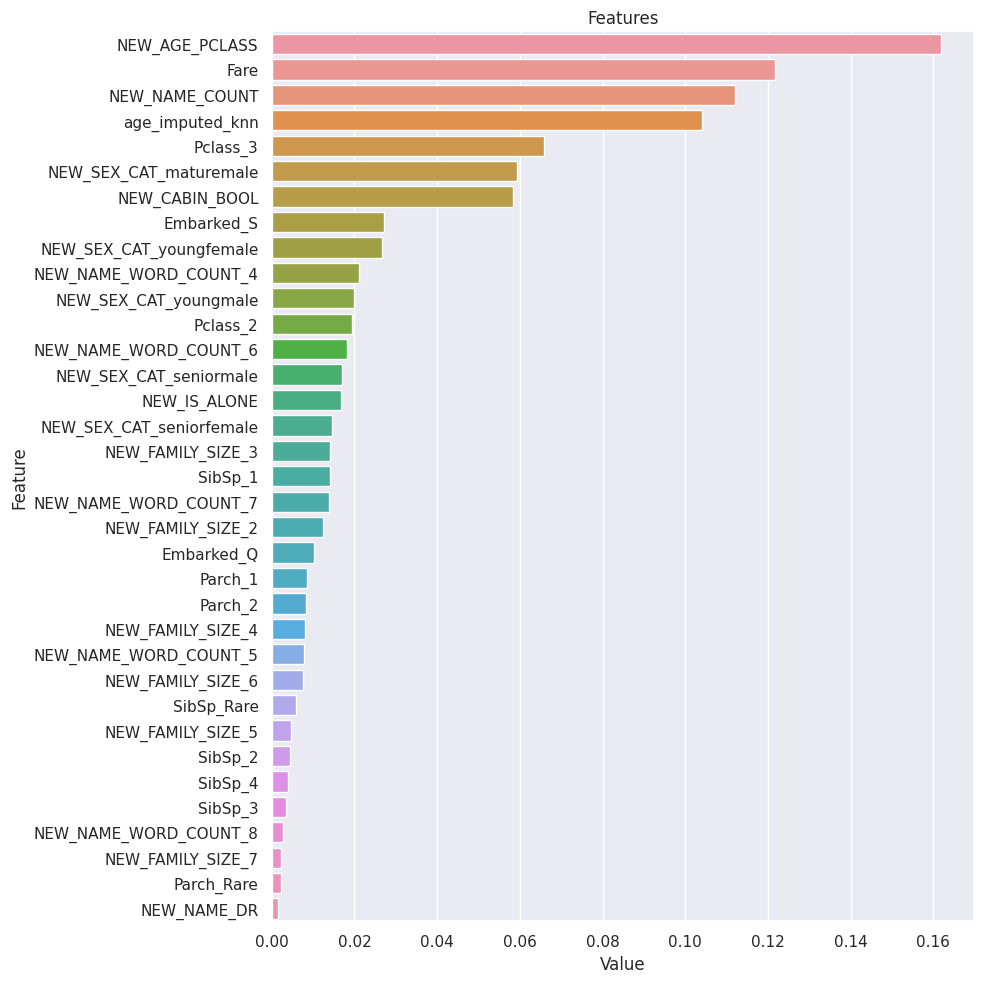

In [210]:

y = df["Survived"]
X = df.drop (["Survived", "PassengerId","Age","Sex","Name","Cabin","Ticket","NEW_TITLE"], axis=1)

################################################
# Feature Importance
################################################
# As it seen below on the graphics, recently created new features with Feature Engineering
# Played a major role in decision making process

# Firstly, There is a need to reshape the data after feature engineering
# In order to solve the problem of Make the DataFrame with Uneven Array Lengths
# This problem occurs after KNN inmputed Age variable,
# KNN Imputed Ages just have been created with a demonstration purpose

def f(x):
    vals = x[~x.isnull()].values
    vals = np.resize(vals, len(x))
    return vals
df = df.apply(f, axis=0)

def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

plot_importance(rf_final, X)



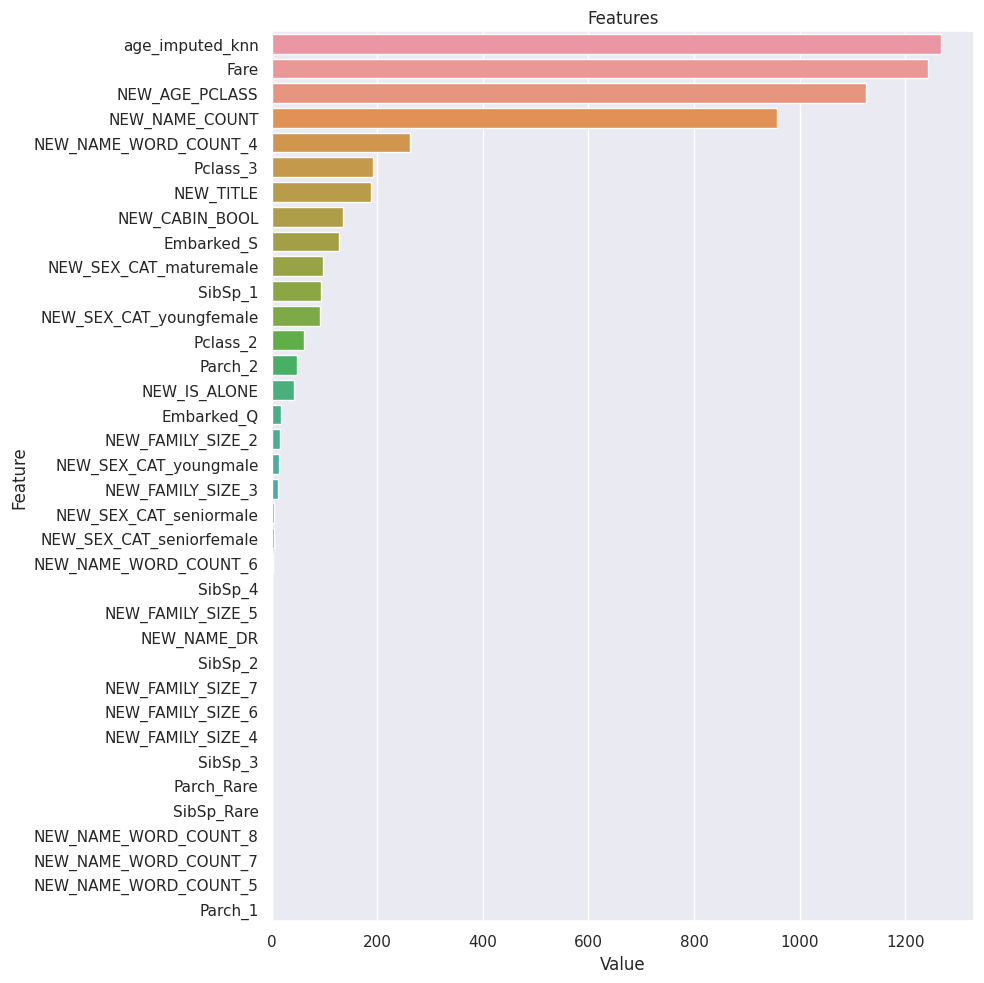

In [212]:
y = df["Survived"]
X = df.drop (["Survived", "PassengerId","Age","Sex","Name","Cabin","Ticket",], axis=1)
plot_importance(lgbm_final, X)

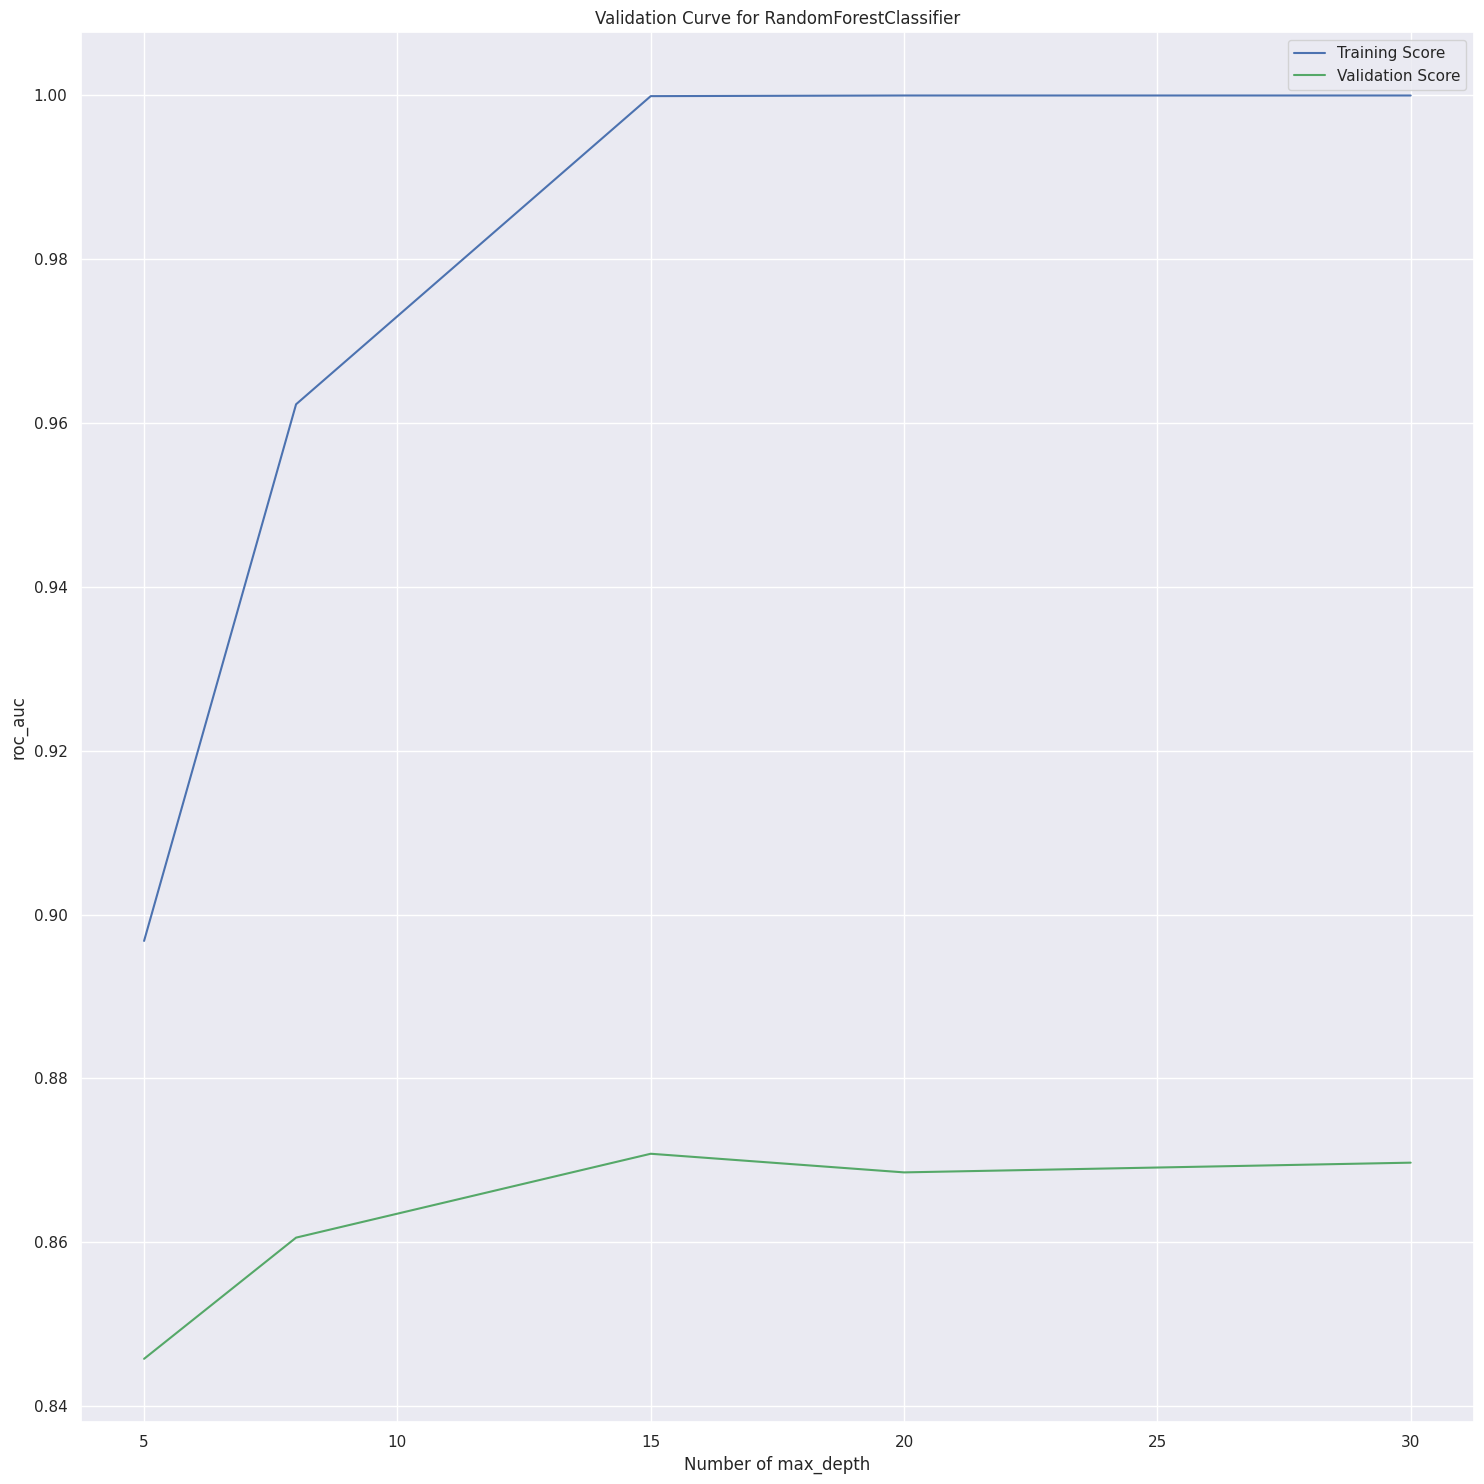

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFor

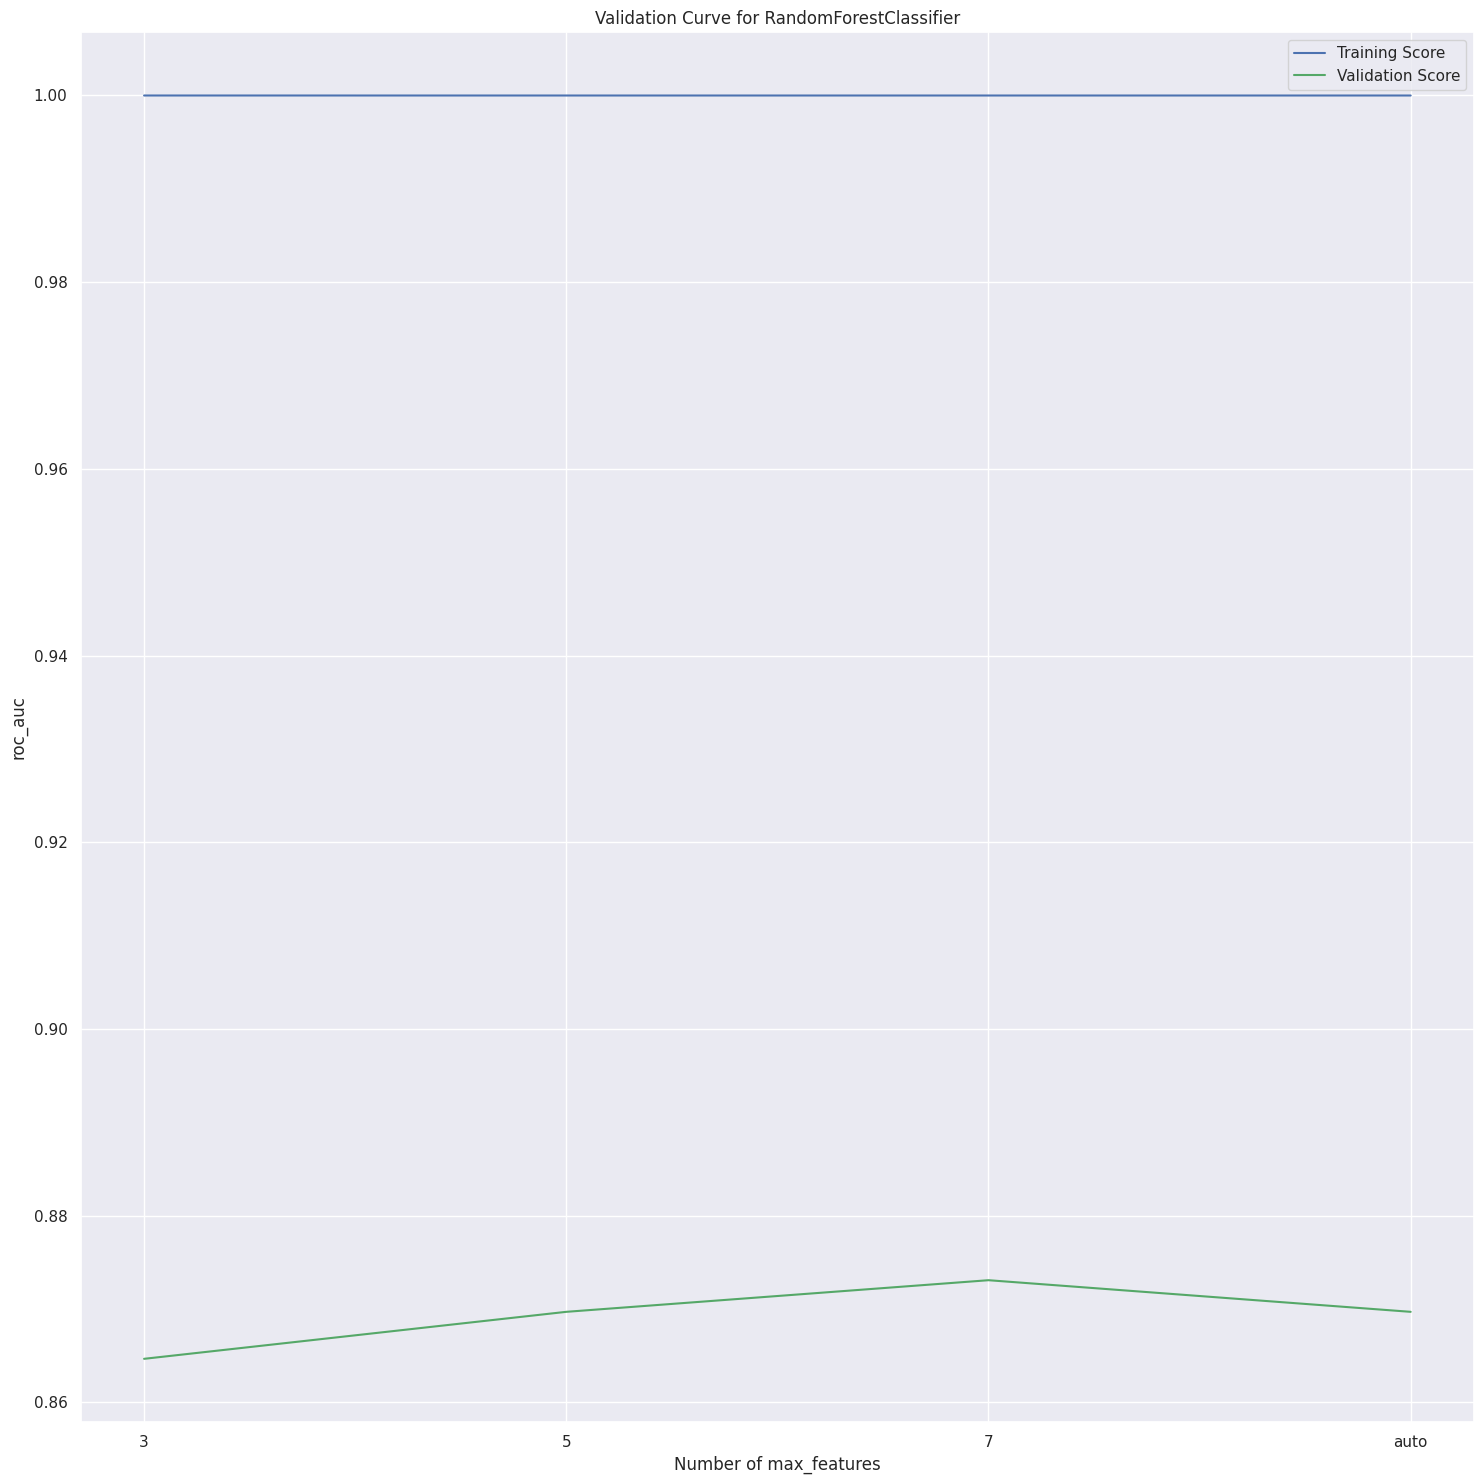

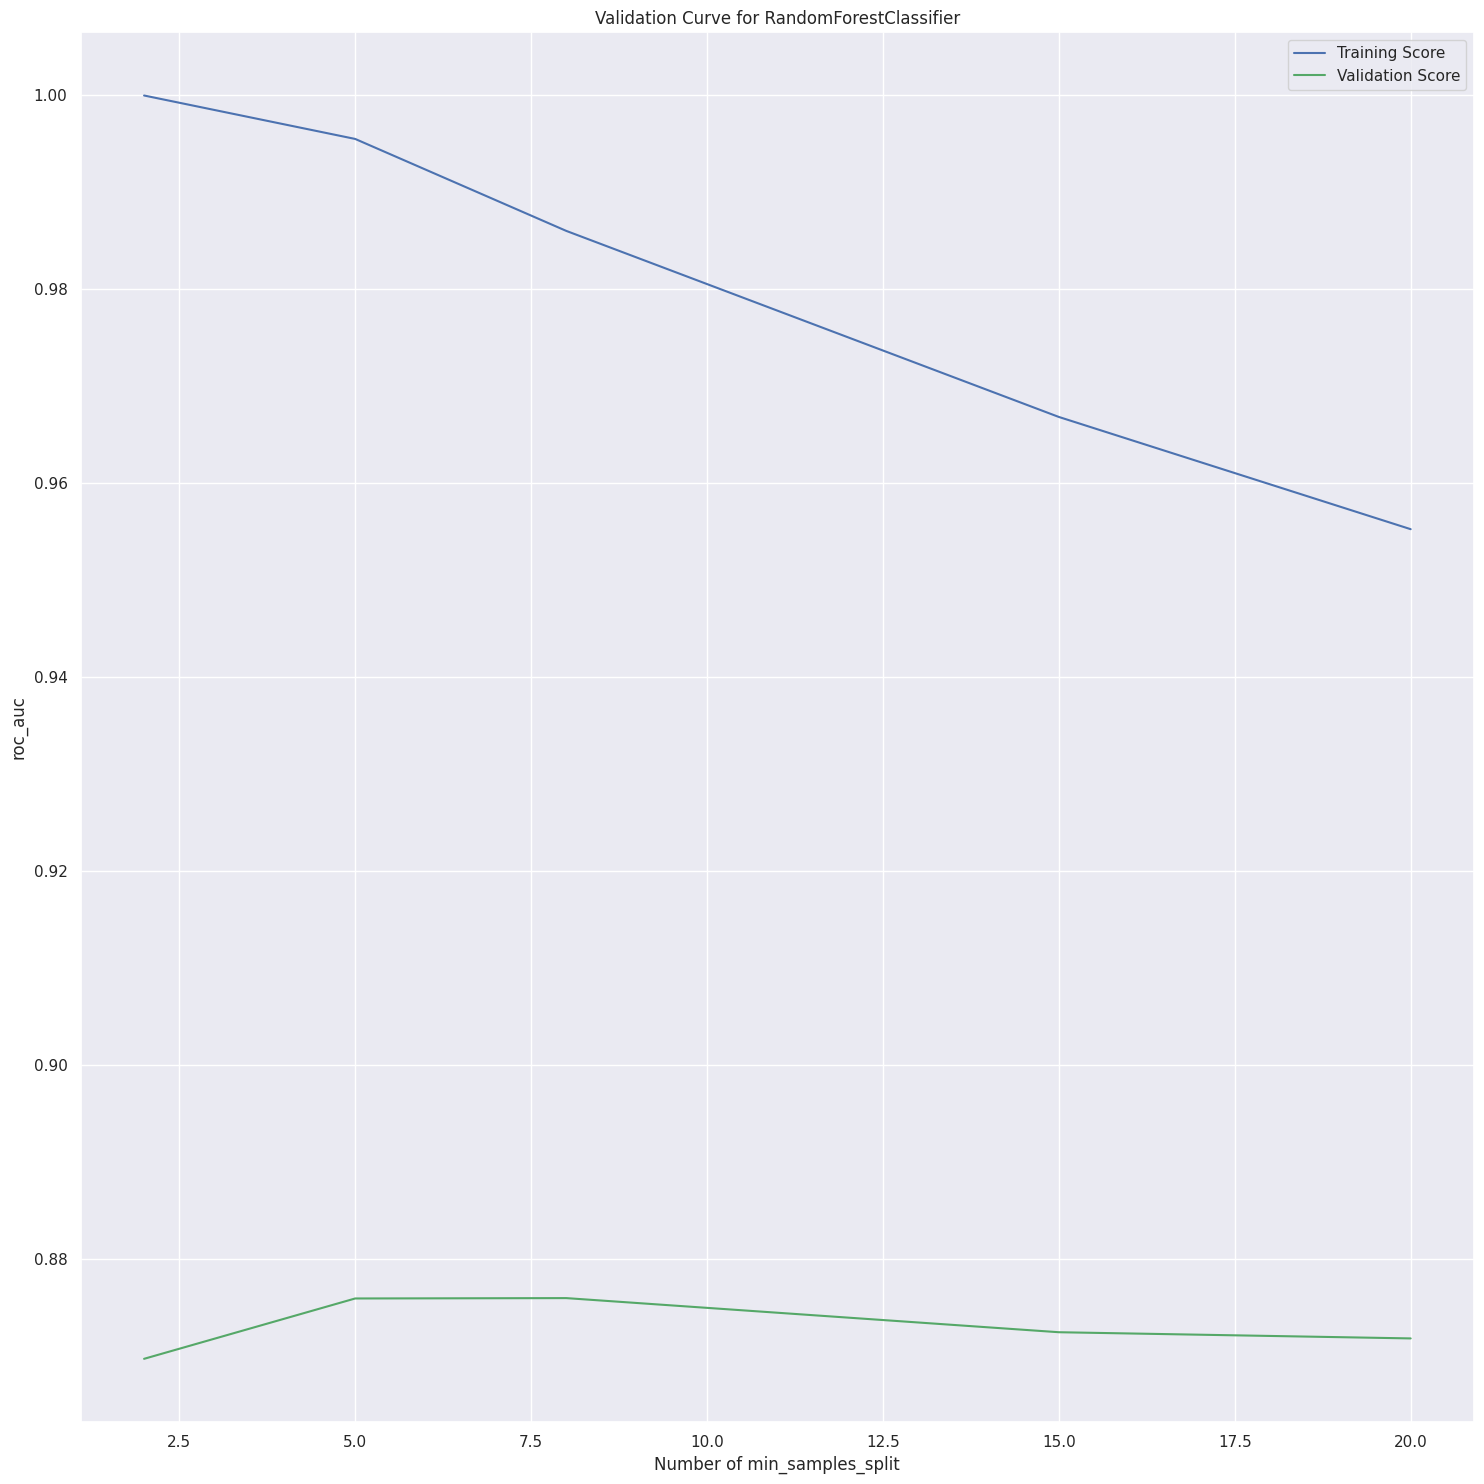

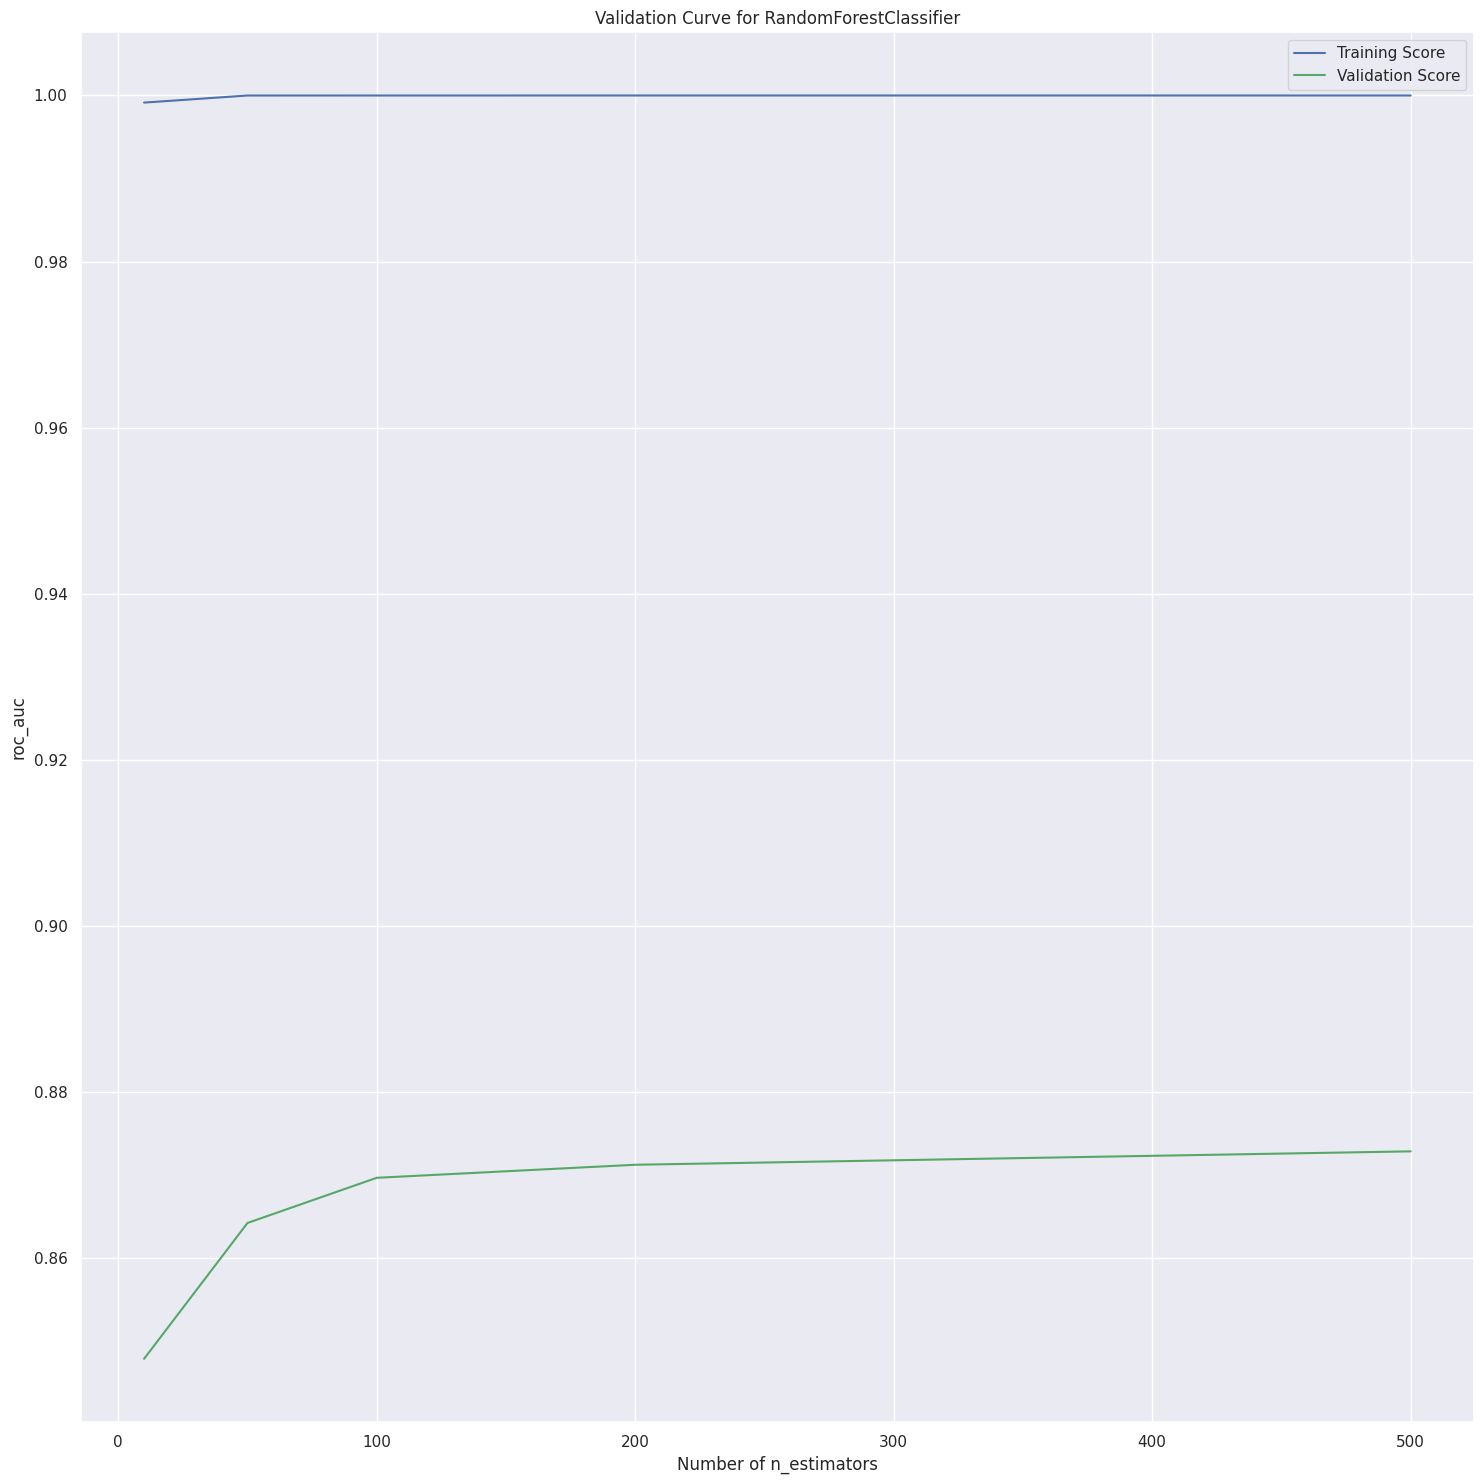

[5, 8, 15, 20, 30, None]

In [213]:
##########################################################
# Analyzing Model Complexity with Learning Curves (BONUS)
##########################################################
y = df["Survived"]
X = df.drop (["Survived", "PassengerId","Age","Sex","Name","Cabin","Ticket","NEW_TITLE"], axis=1)

def val_curve_params(model, X, y, param_name, param_range, scoring="roc_auc", cv=10):
    train_score, test_score = validation_curve(
        model, X=X, y=y, param_name=param_name, param_range=param_range, scoring=scoring, cv=cv)

    mean_train_score = np.mean(train_score, axis=1)
    mean_test_score = np.mean(test_score, axis=1)

    plt.plot(param_range, mean_train_score,
             label="Training Score", color='b')

    plt.plot(param_range, mean_test_score,
             label="Validation Score", color='g')

    plt.title(f"Validation Curve for {type(model).__name__}")
    plt.xlabel(f"Number of {param_name}")
    plt.ylabel(f"{scoring}")
    plt.tight_layout()
    plt.legend(loc='best')
    plt.show(block=True)


rf_val_params = [["max_depth", [5, 8, 15, 20, 30, None]],
                 ["max_features", [3, 5, 7, "auto"]],
                 ["min_samples_split", [2, 5, 8, 15, 20]],
                 ["n_estimators", [10, 50, 100, 200, 500]]]


rf_model = RandomForestClassifier(random_state=17)

for i in range(len(rf_val_params)):
    val_curve_params(rf_model, X, y, rf_val_params[i][0], rf_val_params[i][1])

rf_val_params[0][1]
